# Project Summary

## Overview
__Problem Satement__:  
Which factors affect the persistency of drug use?  

__Dataset__: [Classification: Persistent vs. Non-Persistent](https://www.kaggle.com/datasets/harbhajansingh21/persistent-vs-nonpersistent/data)  


## Results Summarized

Overall Performance:
* All of our models perform well above the base threshold of 61.56% accuracy
  * most perform at around 80% accuracy

Notes on Models Specifically:
* Best Peforming Model: Naive Bayes, Accuracy: 81.43%
  * This could be because a majority of the data is categorical data that was One-Hot Encoded
* Decision Tree models performed the worst on average
* Modles that utilized linear decision boundaries performed better on average

Notes on Data itself:
* A significant amount of features do not have much of a correlation to the target variable
  * Exact number is 79

Features to Note:  
* Dexa_During_Rx
  * Most common factor to affect Persistency
  * DEXA is a specialized x-ray scan to measure bone density
  * A patient is more likely to be persistent with their medication if they have frequent DEXA scans because they are in frequent contact with their doctor and medical testing.
* Comorb_\<One-Hot Encoded Feature\>
  * Multiple One-Hot Encoded features included Comorb → Comorbidity is a commonality
 * Comorb_<> have positive mean weights → Persistent prediction
* Concom_Narcotics
  * Presence of narcotics within patient medical records leads to non-persistence when starting a new therapy regimen

# Preparring Environment

## Loading Packages

In [ ]:
# general
import pandas as pd
import numpy as np
import math

# plotting and displaying information
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from tabulate import tabulate
from pandas.plotting import scatter_matrix

# data processing and formatting
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler, StandardScaler # numerical data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, FunctionTransformer # categorical data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split # splitting dataset

# model specific packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# model optimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

__Catching Warning__: The following function can be used to

In [ ]:
# warning suppression
import warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning
# add any additional warnings you with to filter out

# run before fitting model if model outputs warning message you don't want to see
# warning_types: array of all warning types you wish to suppress
#           - NOTE: all warning types must be imported before being declared
def suppress_warning(warning_types):
    for warn in warning_types:
        warnings.filterwarnings('ignore', category=warn)

## Loading Data

In [ ]:
# select file
filepath = './data/Persistent_vs_NonPersistent.csv'

# # specify any NaN values
# nan_values = []

# loading data and filling in nan_values
df = pd.read_csv(filepath)
print(df.shape)
df.head()

(3424, 69)


,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1


# Exploratory Data Analysis (EDA)

## Summarizing

In [ ]:
print(f'Data Shape: {df.shape}\n')
print(f'Data Types: \n{df.dtypes}')
print(f'All Data Types: {set(df.dtypes)}\n')
print(f'Data Description: \n{df.describe()}\n')
print(f'Count of null values: \n{df.isnull().sum()}')

Data Shape: (3424, 69)

Data Types: 
Ptid                              object
Persistency_Flag                  object
Gender                            object
Race                              object
Ethnicity                         object
                                   ...  
Risk_Hysterectomy_Oophorectomy    object
Risk_Estrogen_Deficiency          object
Risk_Immobilization               object
Risk_Recurring_Falls              object
Count_Of_Risks                     int64
Length: 69, dtype: object
All Data Types: {dtype('O'), dtype('int64')}

Data Description: 
       Dexa_Freq_During_Rx  Count_Of_Risks
count          3424.000000     3424.000000
mean              3.016063        1.239486
std               8.136545        1.094914
min               0.000000        0.000000
25%               0.000000        0.000000
50%               0.000000        1.000000
75%               3.000000        2.000000
max             146.000000        7.000000

Count of null values: 
Ptid      

In [ ]:
null_features = []

for feature in df.columns:
    if df[feature].isnull().sum() != 0:
        null_features.append(feature)

print(f'Features with null values: {null_features}')

Features with null values: []


In [ ]:
# target feature
y_feature = 'Persistency_Flag' # target feature
# all features for prediction
x_features = list(df.drop(columns=['Ptid','Persistency_Flag'],axis=1).columns) # features to predict target

# all categorical features in x_features
categorical_features = list((df.drop(columns=['Ptid','Persistency_Flag'],axis=1).select_dtypes(include='object')).columns) # categorical features
# all numerical features in x_features
numerical_features = list((df.drop(columns=['Ptid','Persistency_Flag'],axis=1).select_dtypes(include='number')).columns) # numerical features

# visualzing feature breakdown
print(f'Y (Target) feature: {y_feature}')
print(f'X features: {len(x_features)}')
print(f'Categorical Features: Number = {len(categorical_features)}\n\t{categorical_features}')
print(f'Numerical Features: Number = {len(numerical_features)}\n\t{numerical_features}')

Y (Target) feature: Persistency_Flag
X features: 67
Categorical Features: Number = 65
	['Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx', 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 'Comorb_Encounter_For_Immunization', 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Vitamin_D_Deficiency', 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified', 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx', 'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia', 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 'Comorb_Other_Disor

### Examining what categorical variables are binary

In [ ]:
categorical_data = df[categorical_features]

for feature in categorical_features:
    values = list(set(df[feature]))
    print(f'{feature}: Number = {len(values)}\n\t{values}')

Gender: Number = 2
	['Female', 'Male']
Race: Number = 4
	['Other/Unknown', 'Asian', 'Caucasian', 'African American']
Ethnicity: Number = 3
	['Not Hispanic', 'Unknown', 'Hispanic']
Region: Number = 5
	['West', 'Other/Unknown', 'South', 'Midwest', 'Northeast']
Age_Bucket: Number = 4
	['55-65', '65-75', '<55', '>75']
Ntm_Speciality: Number = 36
	['Unknown', 'RADIOLOGY', 'UROLOGY', 'TRANSPLANT SURGERY', 'ENDOCRINOLOGY', 'NEUROLOGY', 'GASTROENTEROLOGY', 'ORTHOPEDICS', 'HEMATOLOGY & ONCOLOGY', 'PODIATRY', 'ORTHOPEDIC SURGERY', 'PULMONARY MEDICINE', 'EMERGENCY MEDICINE', 'NEPHROLOGY', 'OPHTHALMOLOGY', 'PATHOLOGY', 'PSYCHIATRY AND NEUROLOGY', 'VASCULAR SURGERY', 'SURGERY AND SURGICAL SPECIALTIES', 'NUCLEAR MEDICINE', 'HOSPICE AND PALLIATIVE MEDICINE', 'PEDIATRICS', 'PLASTIC SURGERY', 'OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY', 'ONCOLOGY', 'OBSTETRICS AND GYNECOLOGY', 'RHEUMATOLOGY', 'PHYSICAL MEDICINE AND REHABILITATION', 'OCCUPATIONAL MEDICINE', 'CARDIOLOGY', 'HOSPITAL M

Things to note:  
* certain data, like Age_Bucket, has been discretized
* there is no null values, instead dataset uses 'Unknown' in place of leaving a cell blank
* dataset also contains 'Other/Unknown'

Approach:  
* go through data and replace 'Unknown' with NaN
* organize categorical data into Binary and Non-Binary categorical data

## Visualization

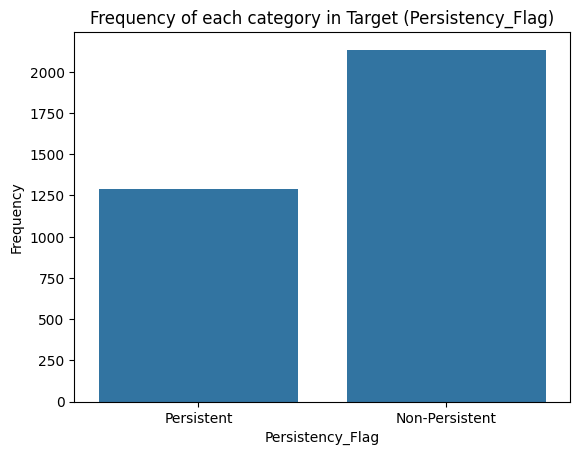

In [ ]:
# setting target
target_feature = 'Persistency_Flag'
# visualizing the target
sns.countplot(x=target_feature, data=df)

# Add title and labels
plt.title(f'Frequency of each category in Target ({target_feature})')
plt.xlabel(target_feature)
plt.ylabel('Frequency')

# Display the plot
plt.show()

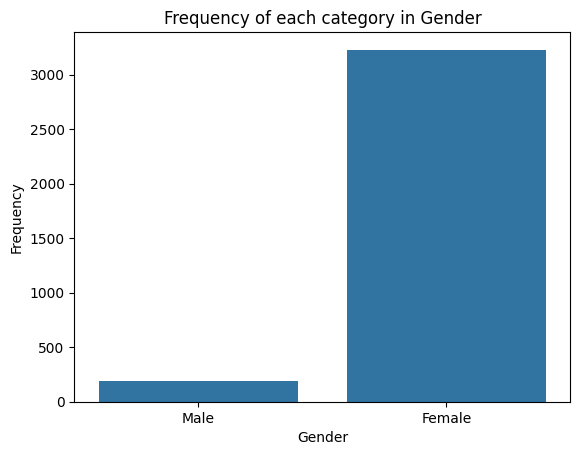

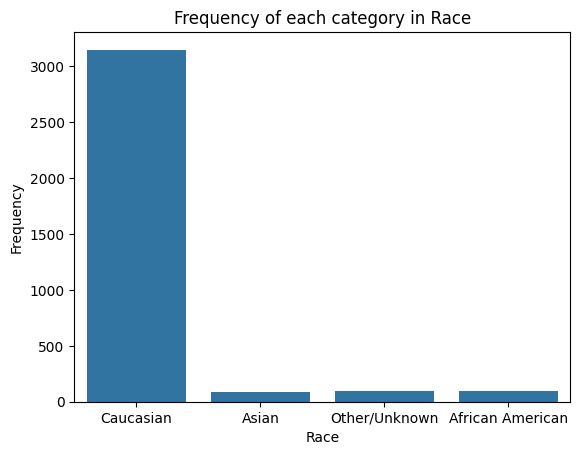

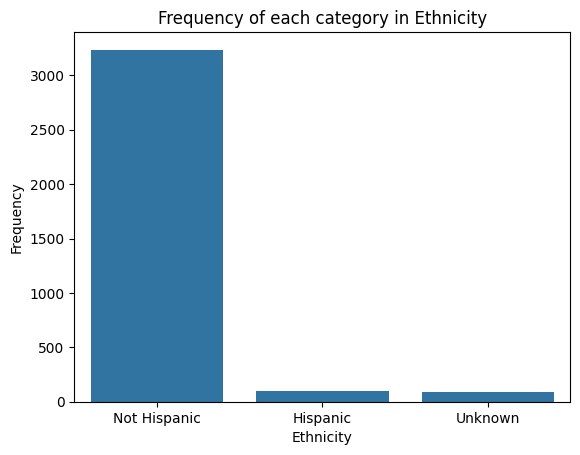

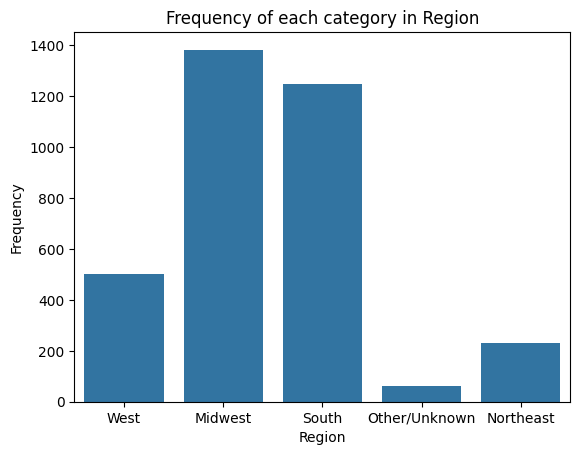

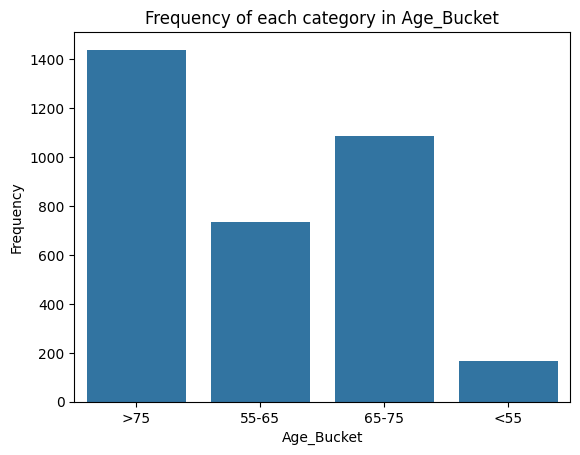

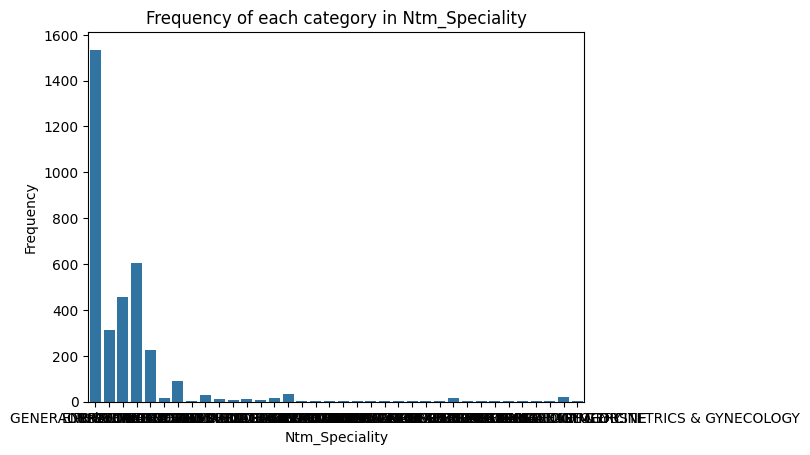

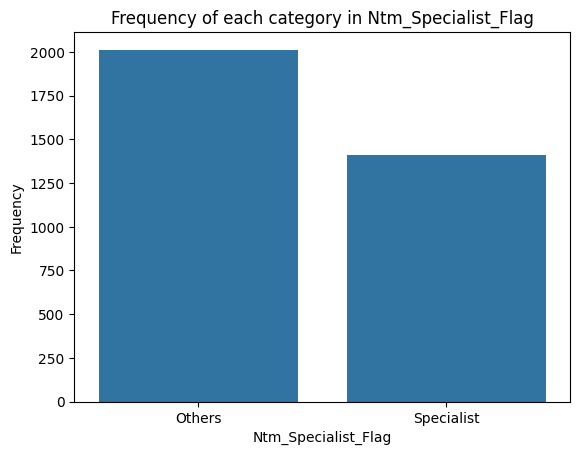

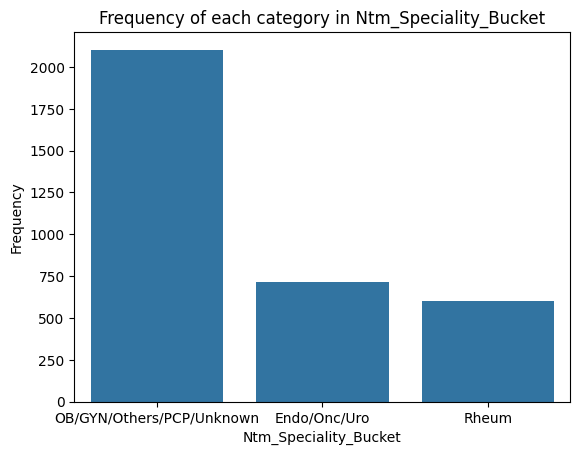

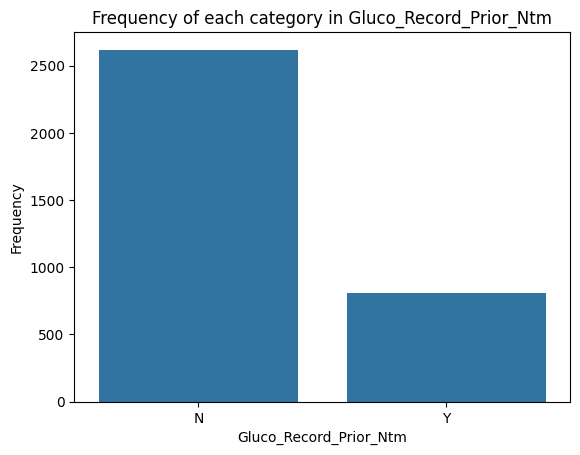

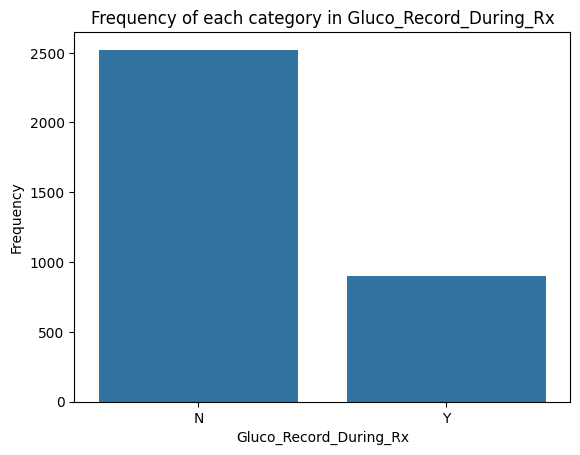

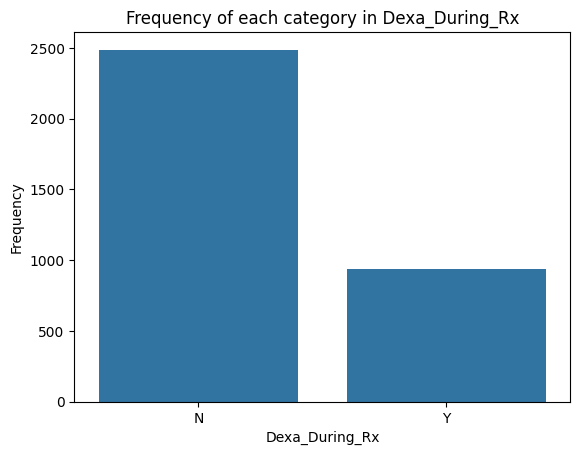

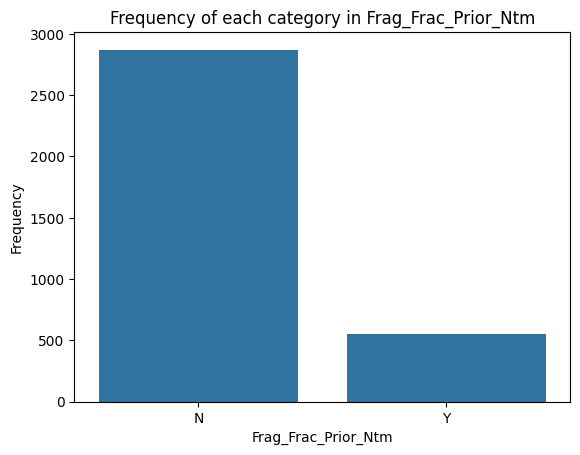

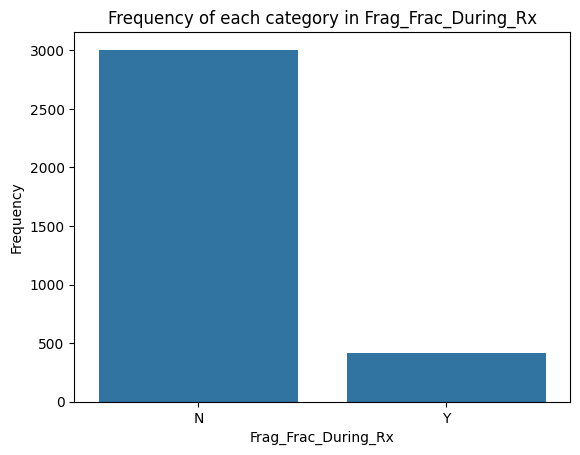

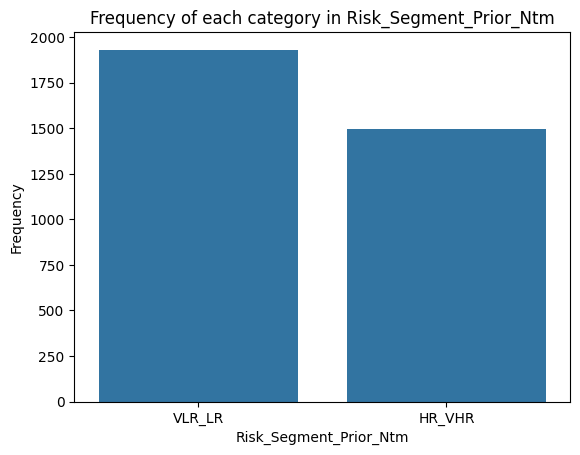

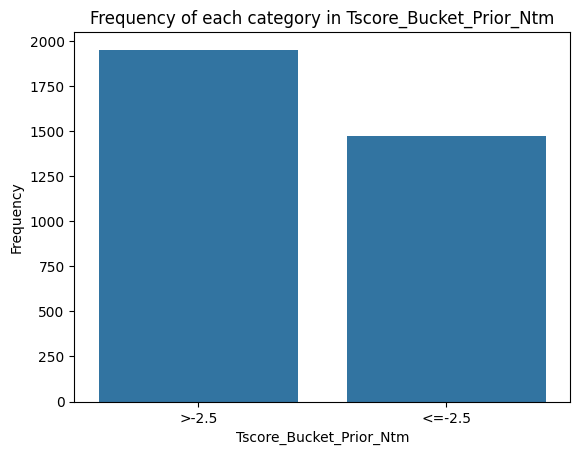

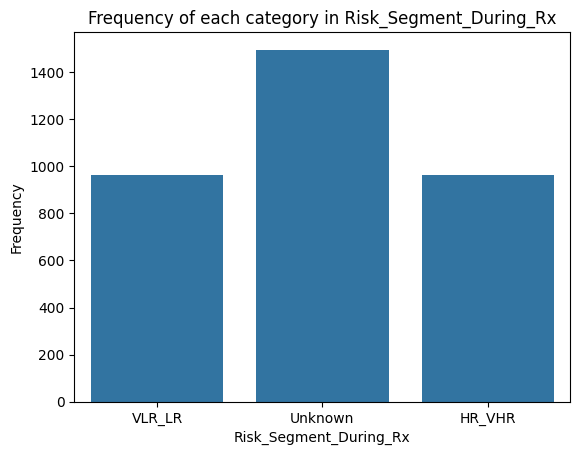

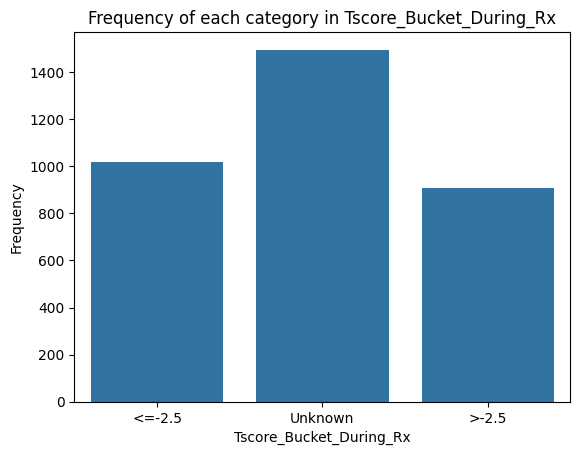

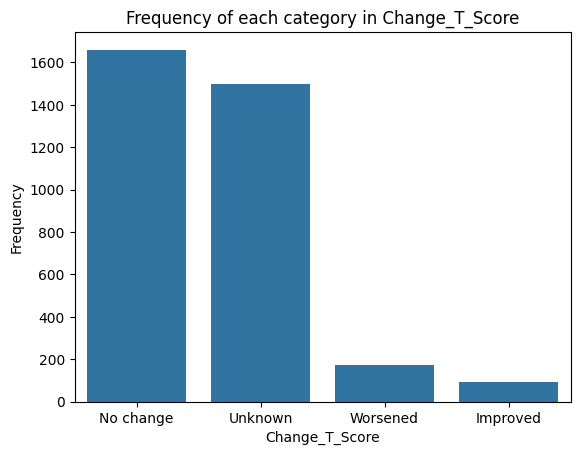

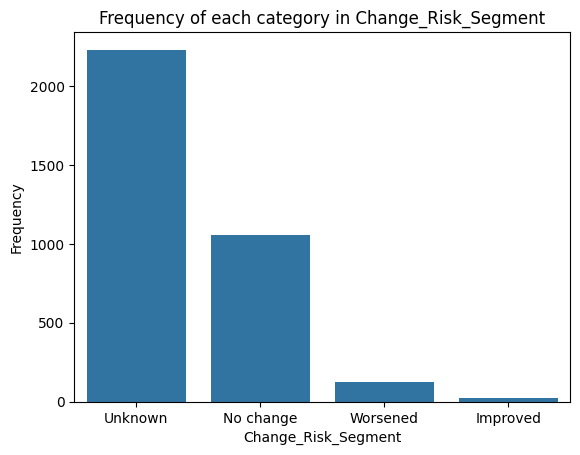

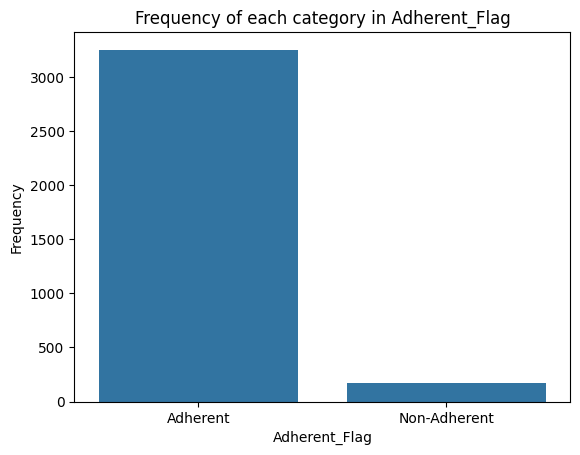

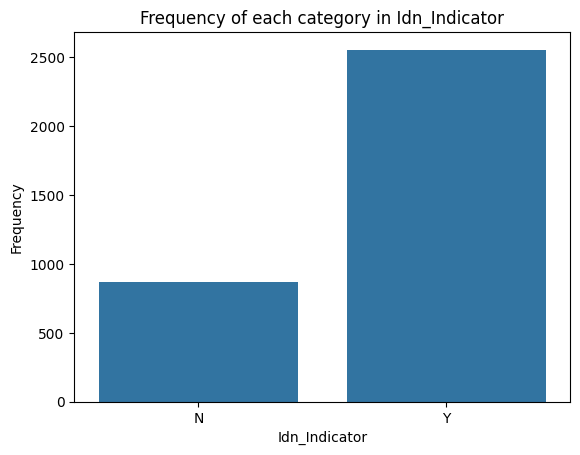

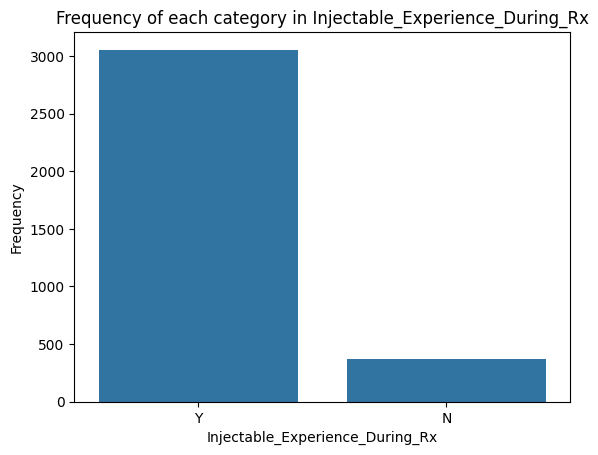

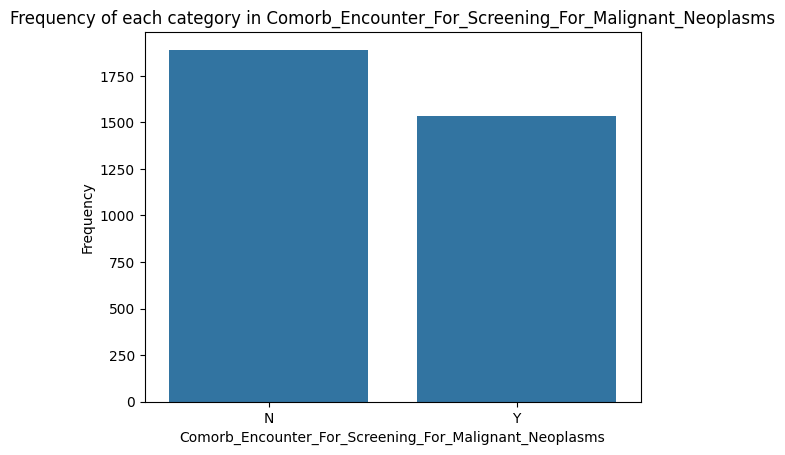

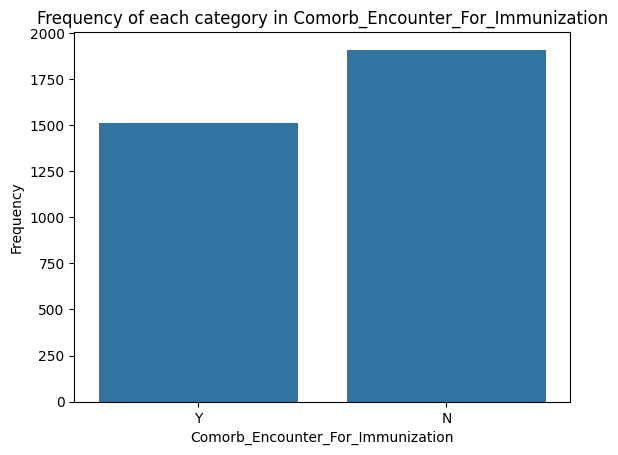

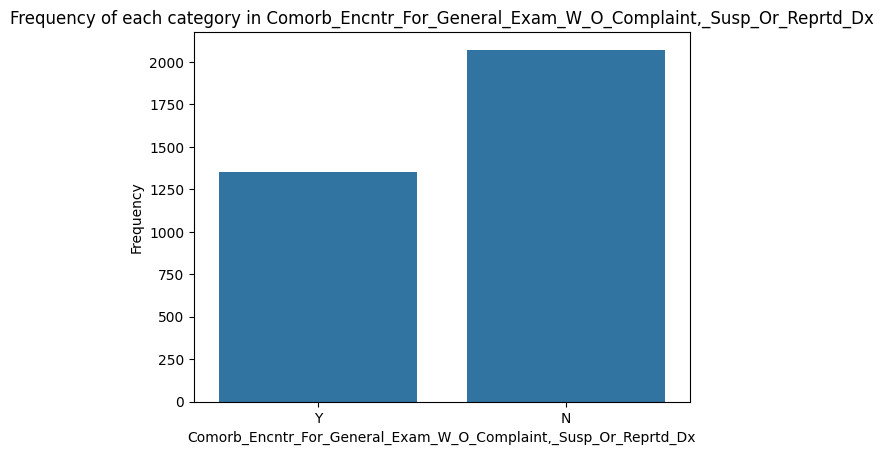

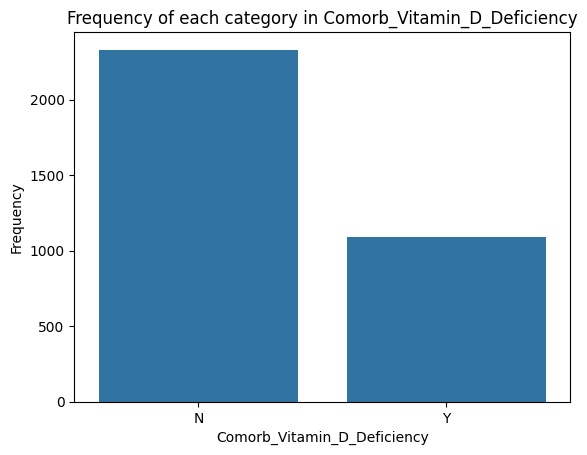

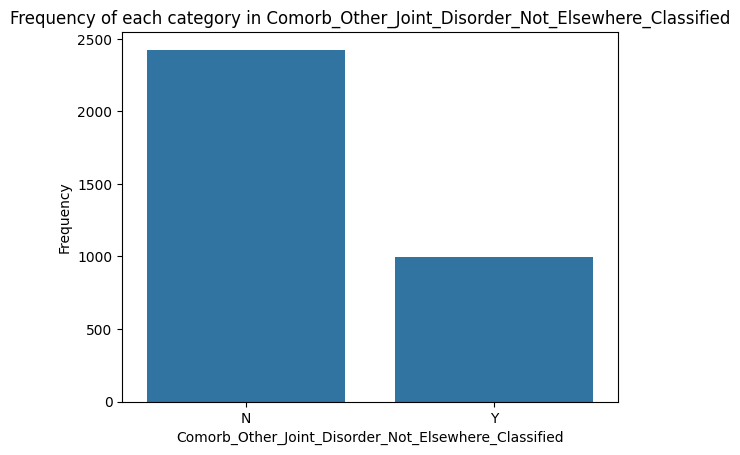

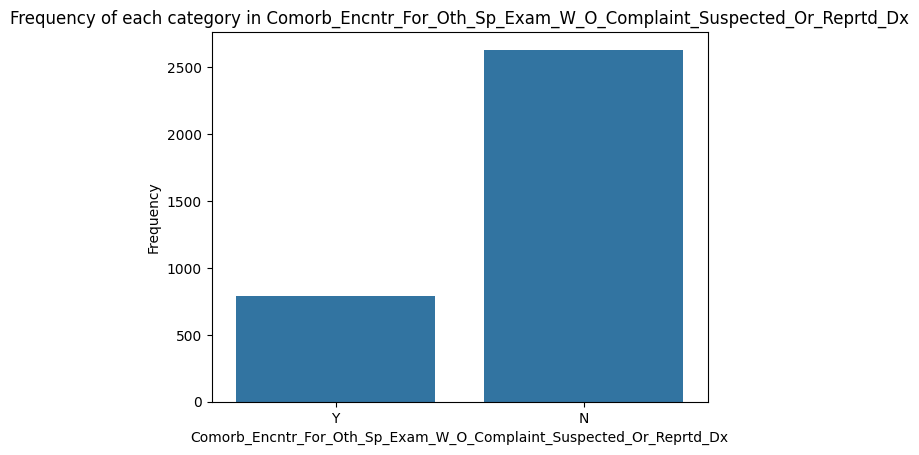

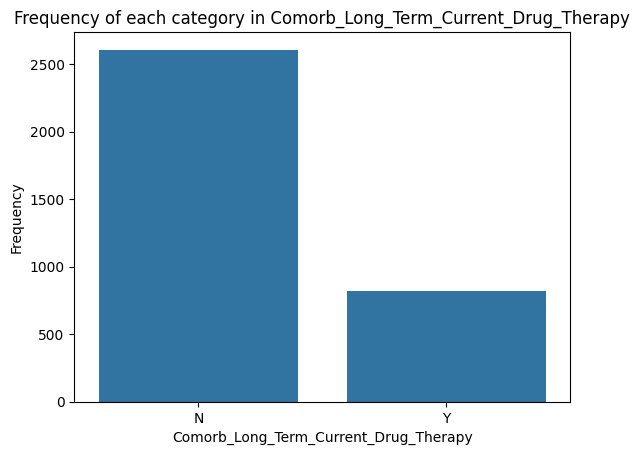

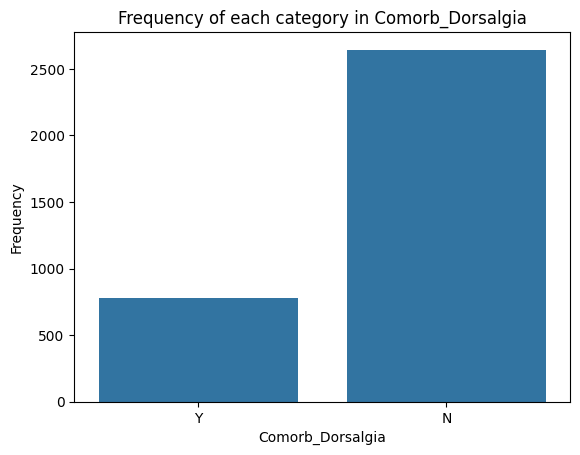

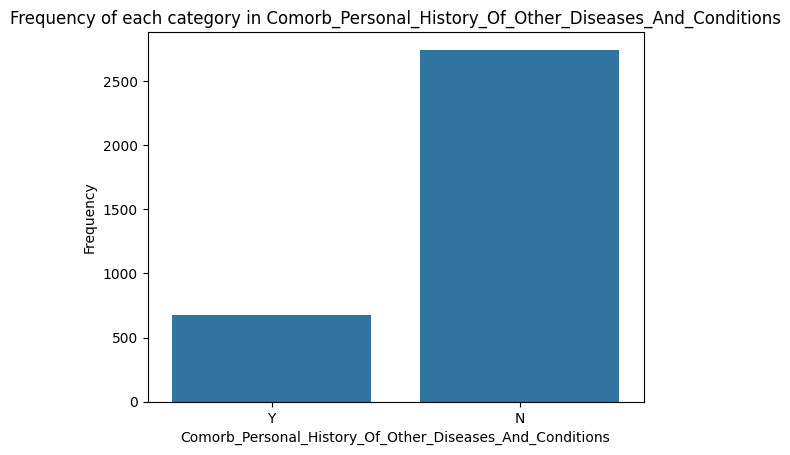

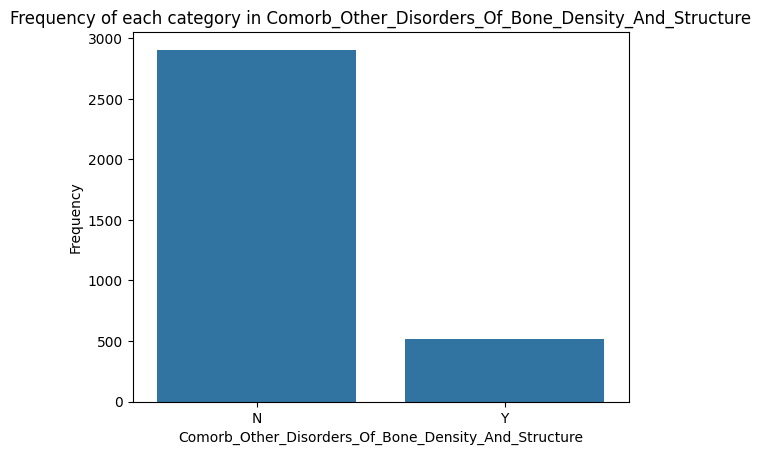

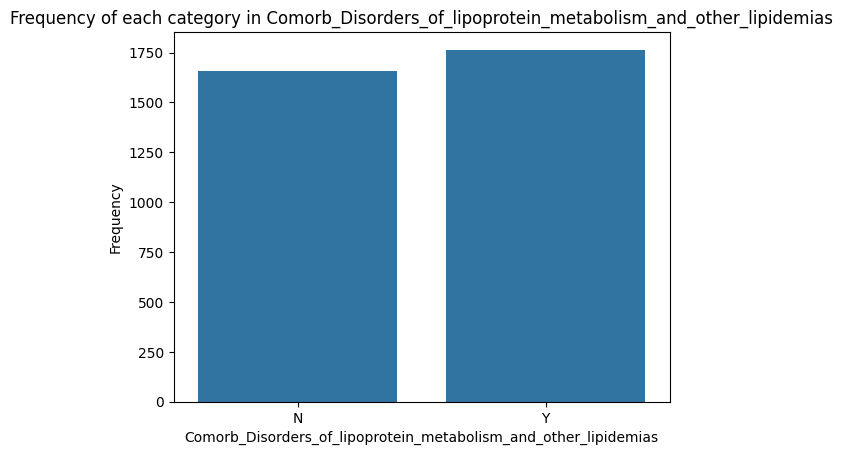

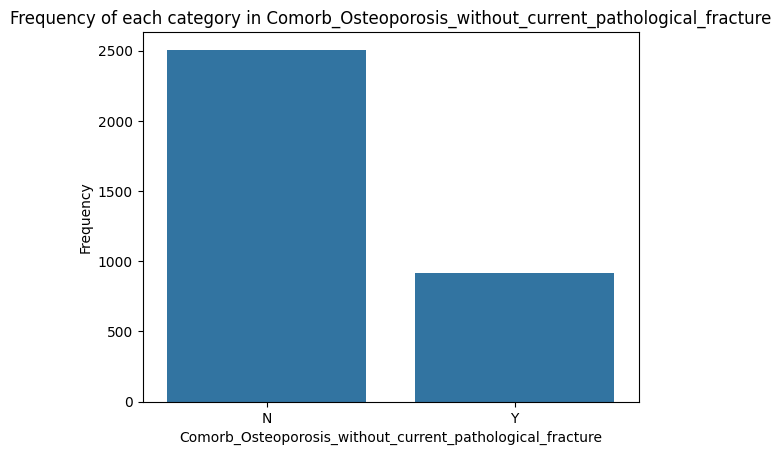

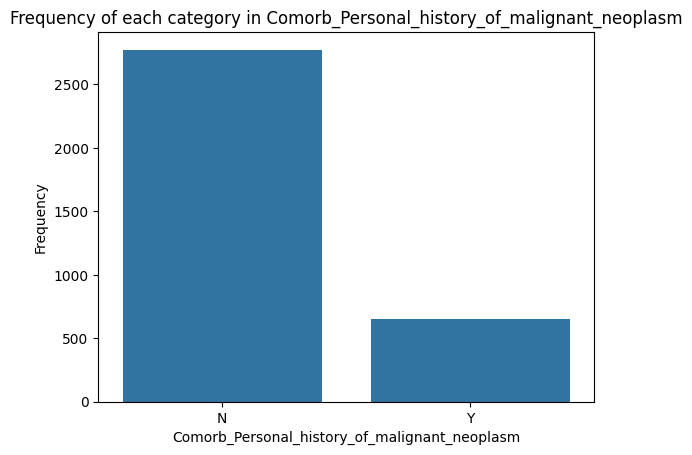

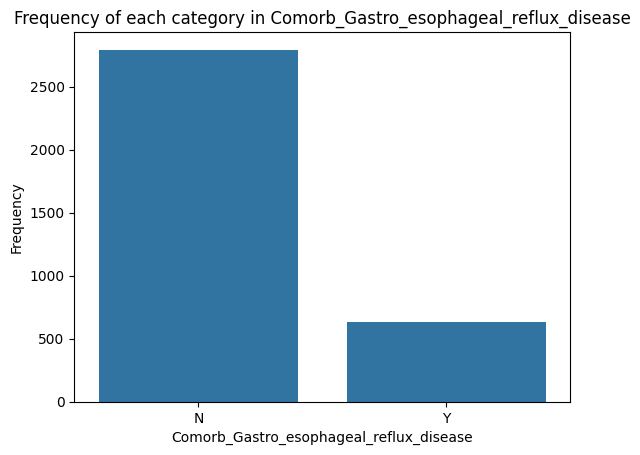

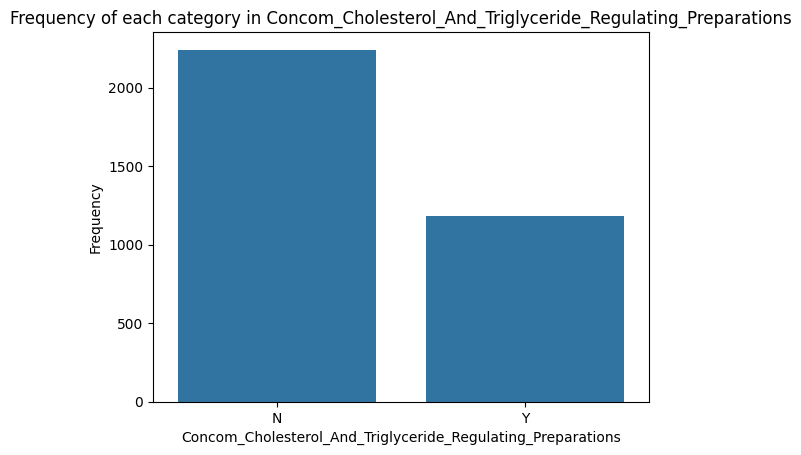

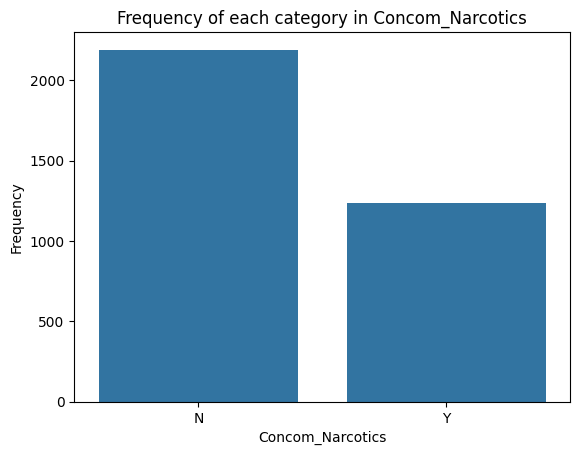

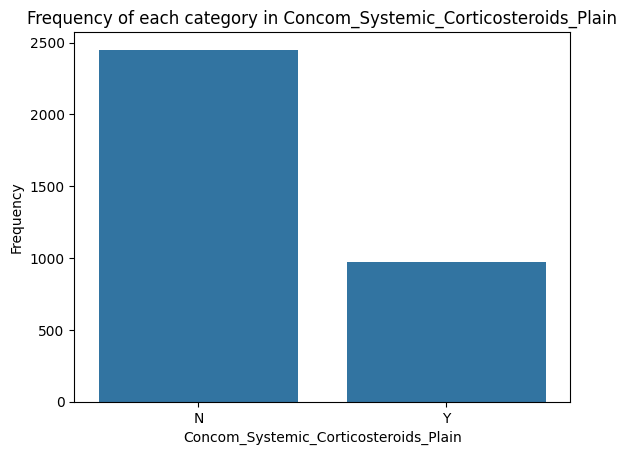

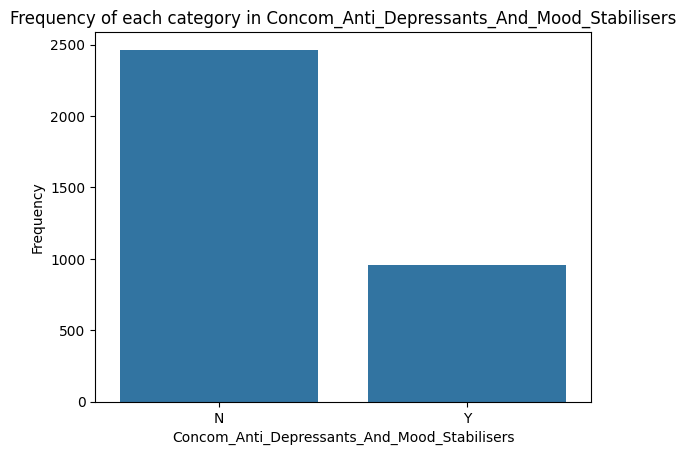

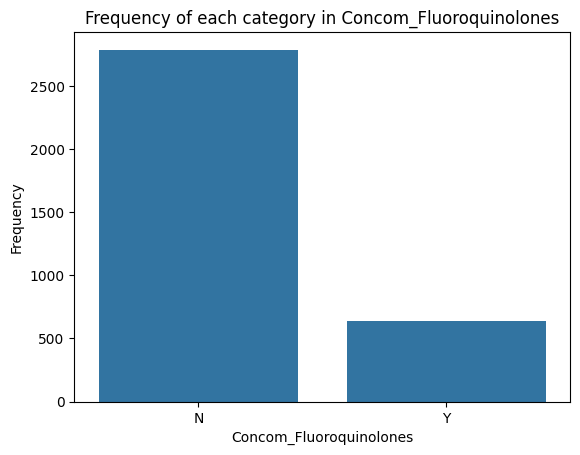

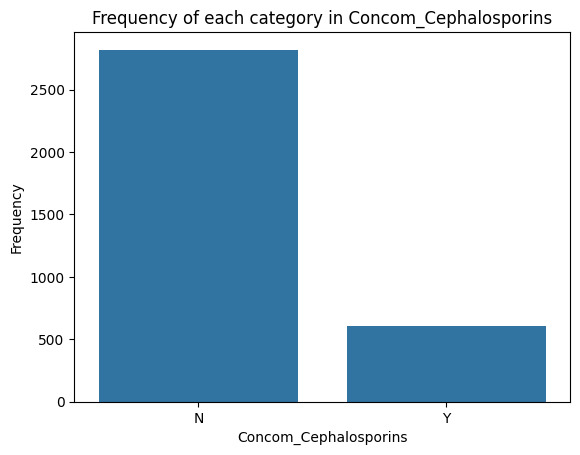

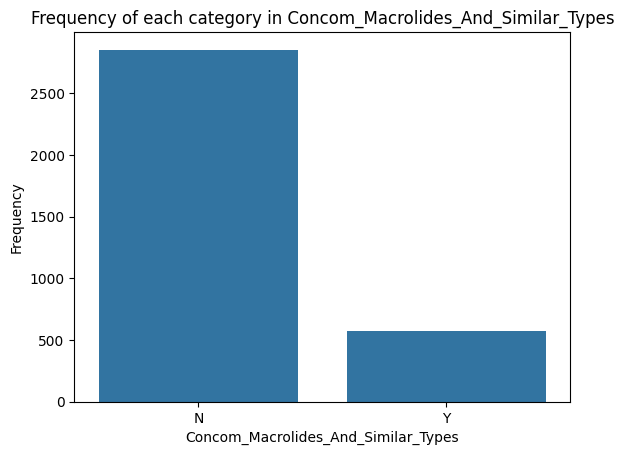

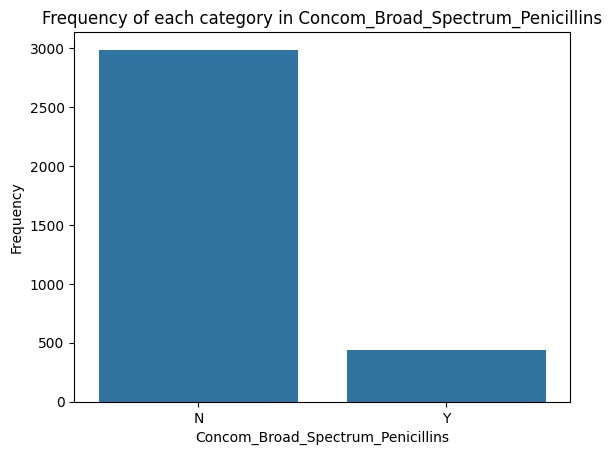

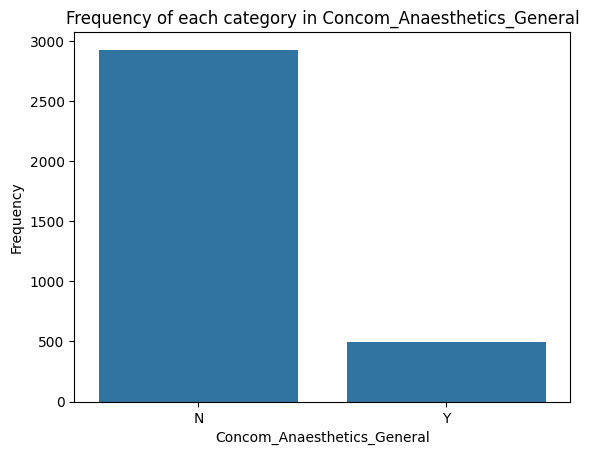

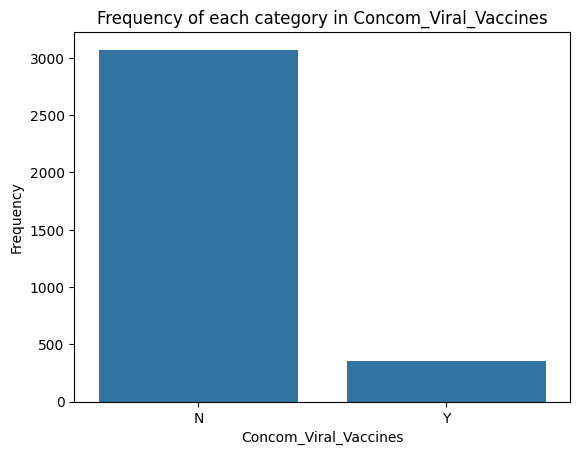

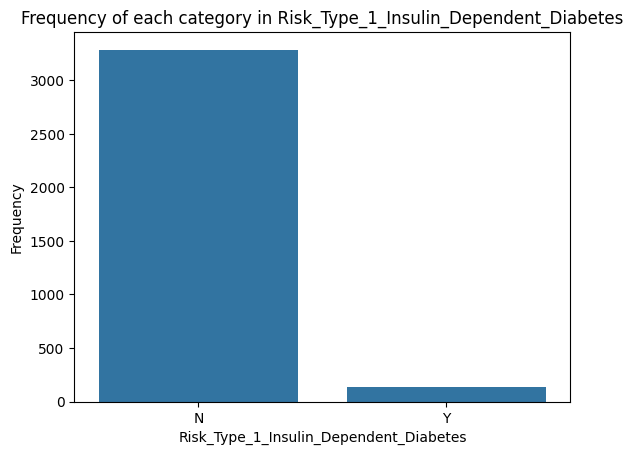

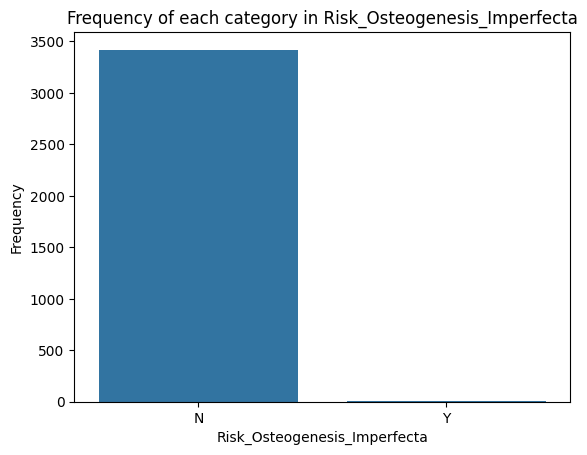

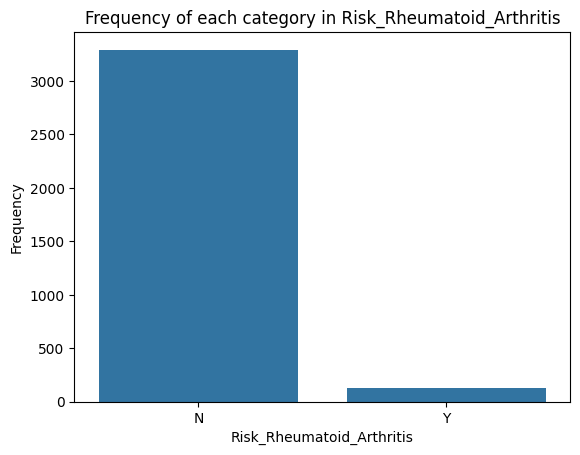

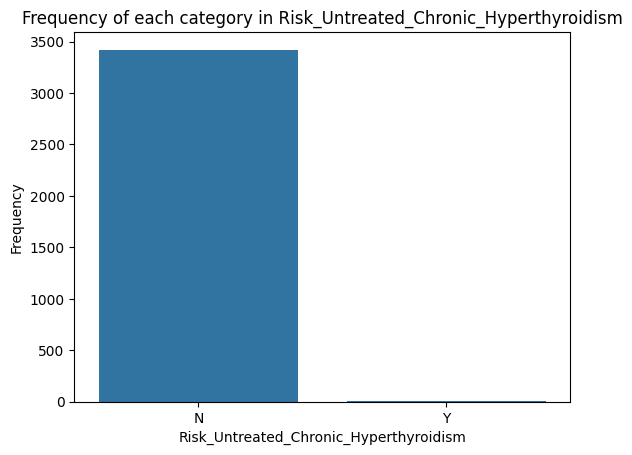

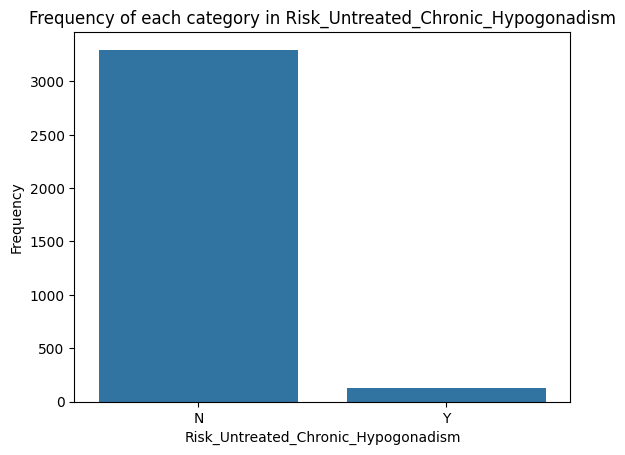

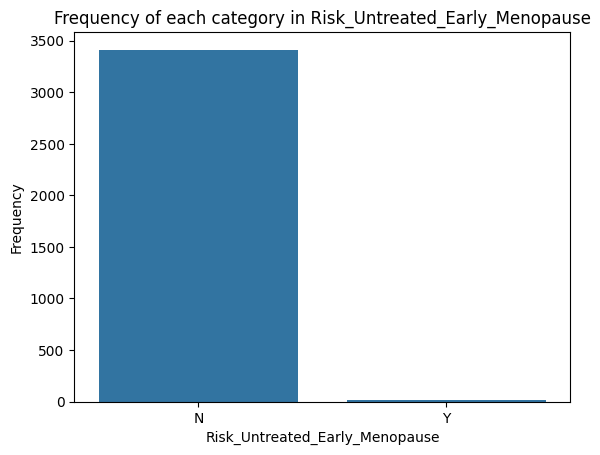

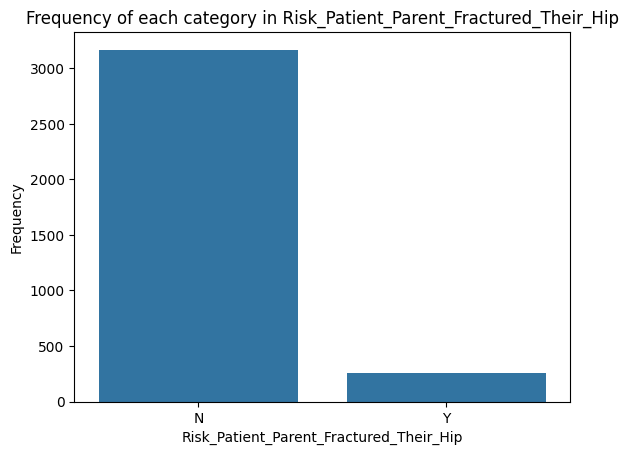

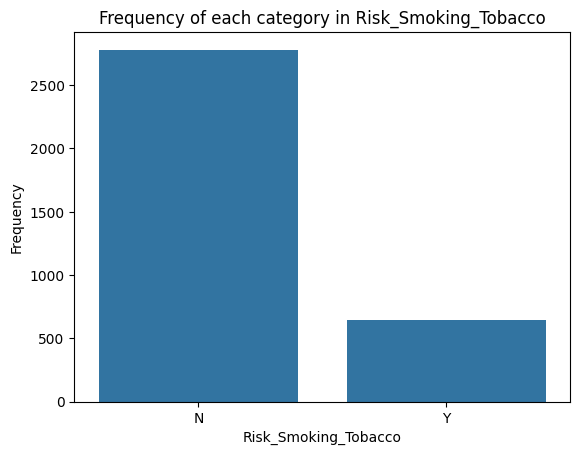

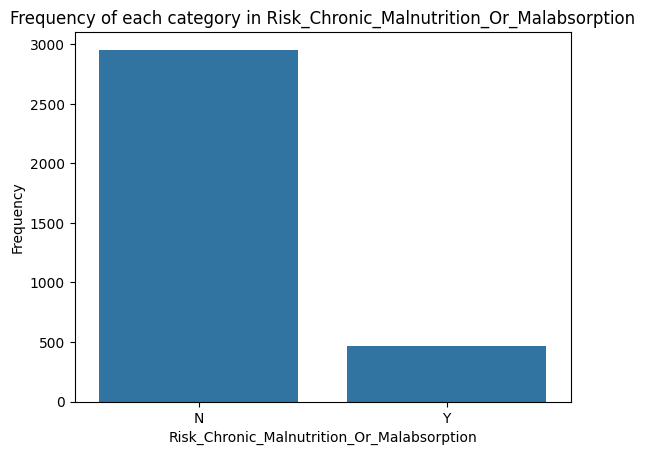

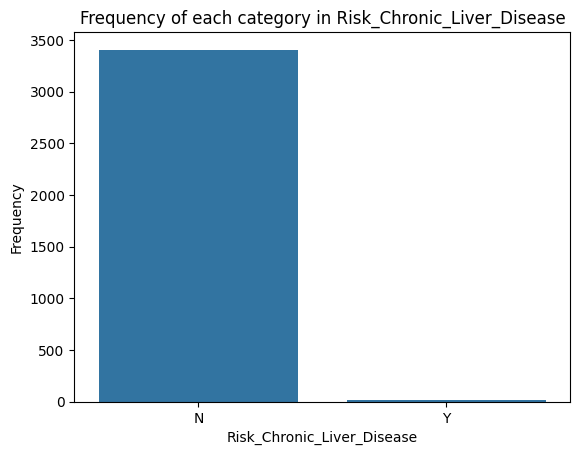

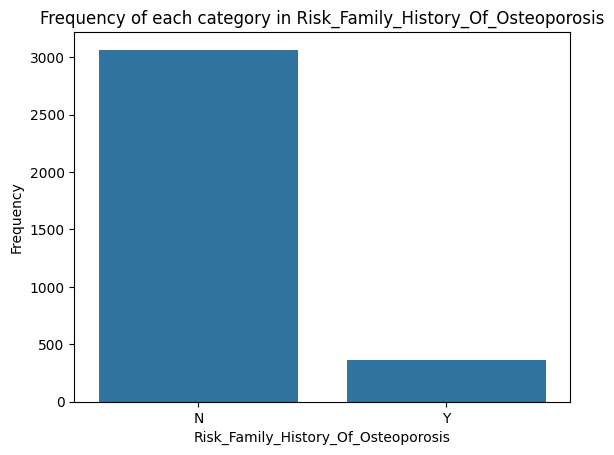

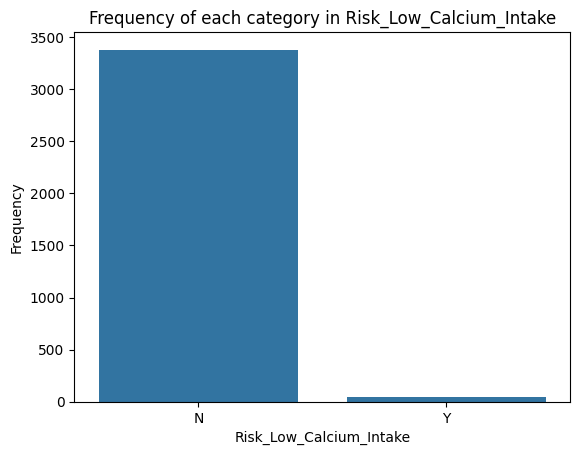

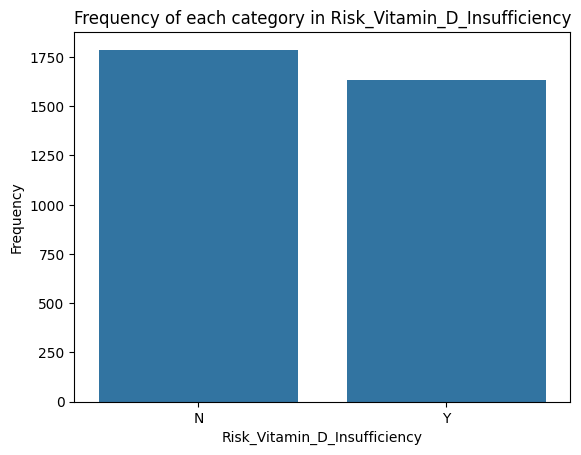

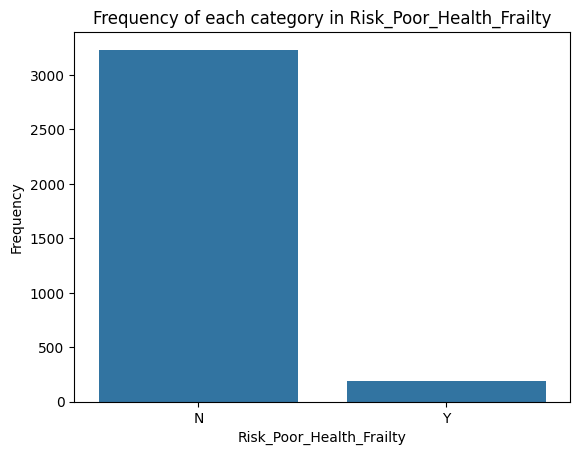

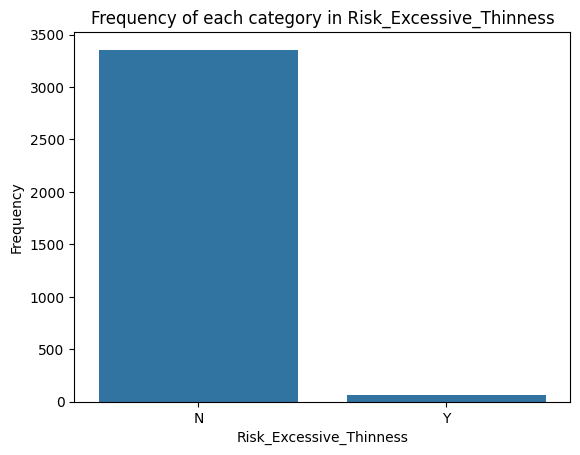

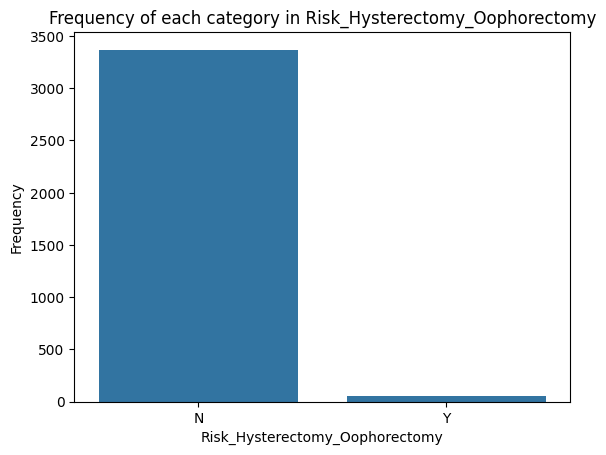

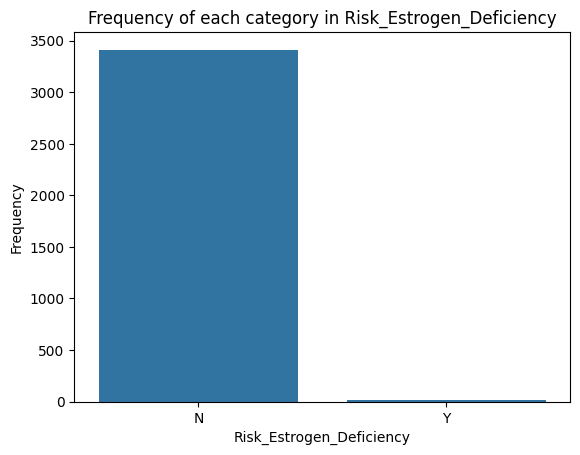

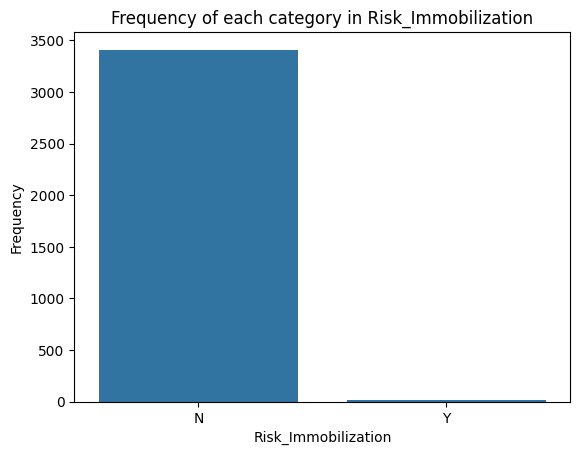

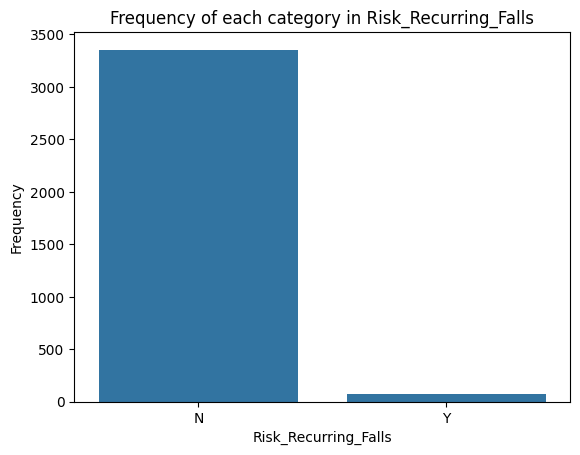

In [ ]:
## UNCOMMENT FOR VISUALIZATION FOR EACH CATEGORICAL FEATURE
# for i in categorical_features:
# # Create a count plot (bar chart) to display the frequency of each category
#     sns.countplot(x=i, data=df)
#     plt.title(f'Frequency of each category in {i}')
#     plt.xlabel(i)
#     plt.ylabel('Frequency')
#     plt.show()

array([[<Axes: xlabel='Dexa_Freq_During_Rx', ylabel='Dexa_Freq_During_Rx'>,
        <Axes: xlabel='Count_Of_Risks', ylabel='Dexa_Freq_During_Rx'>],
       [<Axes: xlabel='Dexa_Freq_During_Rx', ylabel='Count_Of_Risks'>,
        <Axes: xlabel='Count_Of_Risks', ylabel='Count_Of_Risks'>]],
      dtype=object)

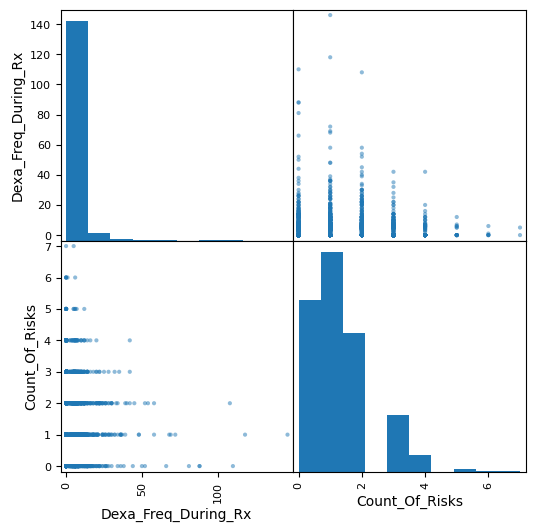

In [ ]:
columns_to_include = ["Dexa_Freq_During_Rx", "Count_Of_Risks", 'Persistency_Flag']
scatter_matrix(df[columns_to_include], figsize=(6, 6), diagonal='hist')

# Data Pre-Processing

In [ ]:
df_working = df.copy()
print(df_working.shape)
df_working.head()

(3424, 69)


,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1


## Dealing with Missing Values

### Replacing 'Unknown'

In [ ]:
# goes through data and outputs list of tuple containing information about features with null values
# data: dataframe
# output: array of form [(null feature name, null count, null percentage)]
def get_null_feat(data):
    null_features = []
    for feature in data.columns:
        null_count = data[feature].isnull().sum()
        null_percentage = null_count / len(data[feature])
        if null_count != 0:
            null_features.append((feature, null_count, null_percentage))
            print(f'Feature: {feature}, \tNull Count: {null_count}, \tNull Percentage: {null_percentage}')
    return null_features

In [ ]:
df_working.replace('Unknown', np.nan, inplace=True)

print(f'Features with null values:')

null_features = get_null_feat(df_working)

Features with null values:
Feature: Ethnicity, 	Null Count: 91, 	Null Percentage: 0.026577102803738317
Feature: Ntm_Speciality, 	Null Count: 310, 	Null Percentage: 0.0905373831775701
Feature: Risk_Segment_During_Rx, 	Null Count: 1497, 	Null Percentage: 0.43720794392523366
Feature: Tscore_Bucket_During_Rx, 	Null Count: 1497, 	Null Percentage: 0.43720794392523366
Feature: Change_T_Score, 	Null Count: 1497, 	Null Percentage: 0.43720794392523366
Feature: Change_Risk_Segment, 	Null Count: 2229, 	Null Percentage: 0.6509929906542056


### Dropping Features/Observations

In [ ]:
# function returns the features with missing value percentage below threshold, used to drop individual observations
# null_features: array containing tuples of (feature_name, null_count, null_percentage) for all features that contain null values
# threshold: float from 0 to 1 representing the percentage of missing observations that needs to be exceeded to drop feature
def features_below_threshold(null_features, threshold):
    above_threshold = []
    for feature, null_count, null_per in null_features:
        if null_per < threshold:
            above_threshold.append(feature)
    return above_threshold

# function returns the features with missing value percentage above threshold, used to drop columns
# null_features: array containing tuples of (feature_name, null_count, null_percentage) for all features that contain null values
# threshold: float from 0 to 1 representing the percentage of missing observations that needs to be exceeded to drop feature
def features_above_threshold(null_features, threshold):
    above_threshold = []
    for feature, null_count, null_per in null_features:
        if null_per >= threshold:
            above_threshold.append(feature)
    return above_threshold

In [ ]:
# determining what observations to drop
below_threshold = 0.1
# gettng observations' to drop columns
subset_drop_observations = features_below_threshold(null_features, below_threshold)
# dropping observations
print(f'Dropping Observations: {subset_drop_observations}')
df_working = df_working.dropna(subset=subset_drop_observations)
df_working.reset_index(drop=True, inplace=True)
print(f'New Shape: {df_working.shape}')

Dropping Observations: ['Ethnicity', 'Ntm_Speciality']
New Shape: (3033, 69)


In [ ]:
# determining what features to drop
above_threshold = 0.6
# getting features to be dropped
features_to_drop = features_above_threshold(null_features, above_threshold)
# dropping features
print(f'Dropping features: {features_to_drop}')
df_working = df_working.drop(columns=features_to_drop,axis=1)
print(f'New Shape: {df_working.shape}')

Dropping features: ['Change_Risk_Segment']
New Shape: (3033, 68)


### Imputing Missing Values

In [ ]:
print(f'Remaining null features:')
null_features = get_null_feat(df_working)

Remaining null features:
Feature: Risk_Segment_During_Rx, 	Null Count: 1285, 	Null Percentage: 0.4236729310913287
Feature: Tscore_Bucket_During_Rx, 	Null Count: 1285, 	Null Percentage: 0.4236729310913287
Feature: Change_T_Score, 	Null Count: 1285, 	Null Percentage: 0.4236729310913287


In [ ]:
# imputes missing values appropriately
# null_features: array containing tuples of (feature_name, null_count, null_percentage) for all features that contain null values
# data: dataframe
# output: dataframe with imputed values
def impute_missing(null_features, data):
    # copying data to not disturb original
    data_imputed = data.copy()
    for feature, null_count, null_per in null_features:
        # getting data type
        feature_dtype = data[feature].dtype
        # imputing missing data
        if is_numeric_dtype(feature_dtype): # numeric: fill in NaN with median value
            data_imputed[feature] = data_imputed[feature].fillna(value=data_imputed[feature].median())
        else: # categorical: fill in NaN with mode value
            data_imputed[feature] = data_imputed[feature].fillna(value=data_imputed[feature].mode()[0])

    return data_imputed

In [ ]:
# imputing missing data values
df_working = impute_missing(null_features, df_working)
print(f'Shape: {df_working.shape}')
print(f'Remaining Null Features: {get_null_feat(df_working)}')

Shape: (3033, 68)
Remaining Null Features: []


## Data Cleaning - Preparation

Since most of the data pre-processing will be more model specific (done right before training a model), we will use a dictionary to hold and reference the components required for the pre-processing.

In [ ]:
pre_processing_log = {} # data-structure to hold pre_processing information

## Target Data

In [ ]:
# getting target feature
target = df_working['Persistency_Flag']
print(f'Target Values: {list(set(target))}')
target.head()

Target Values: ['Persistent', 'Non-Persistent']


0        Persistent
1    Non-Persistent
2    Non-Persistent
3    Non-Persistent
4    Non-Persistent
Name: Persistency_Flag, dtype: object

Since there are only two target values possible, and they are labeled as 'Persistent' and 'Non-Persistent', we will convert their representations to a binary mapping

In [ ]:
# creating mapping for target variable: 1 = 'Persistent', 0 = 'Non-Persistent'
target_mapping = {'Persistent':1, 'Non-Persistent':0}
# mapping target
target_mapped = target.map(target_mapping)
print(target_mapped.shape)
target_mapped.head()

(3033,)


0    1
1    0
2    0
3    0
4    0
Name: Persistency_Flag, dtype: int64

## Scaling Data

In [ ]:
# getting numerical data
num_features = list((df_working.drop(columns=['Ptid','Persistency_Flag'],axis=1).select_dtypes(include='number')).columns)
num_data = df_working[num_features]
# adding features to log
pre_processing_log['num_feat'] = num_features
print(num_data.shape)
num_data.head()

(3033, 2)


,Dexa_Freq_During_Rx,Count_Of_Risks
0,0,0
1,0,0
2,0,2
3,0,1
4,0,1


In [ ]:
# displaying information about numerical data
num_data.describe()

,Dexa_Freq_During_Rx,Count_Of_Risks
count,3033.000000,3033.000000
mean,3.107155,1.259479
std,8.375862,1.099711
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,4.000000,2.000000
max,146.000000,7.000000


Since there are only two numerical features, and the type of pre-processing required on numerical data is determined by the model being trained, we will not pre-process data in this step and instead make a transformer that will be used for pre-processing
* NOTE: These transformers will be used right before model training via custom pre-processors for each model


WILL MAKE THESE PRE-PROCESSORS AFTER FINALIZING THE FEATURES IN THE FINAL DATAFRAME (I.E. AFTER FEATURE COMBINATION AND DROPPING)

## Processing Categorical Data

In [ ]:
# getting categorical data
cat_features = list((df_working.drop(columns=['Ptid','Persistency_Flag'],axis=1).select_dtypes(include='object')).columns)
cat_data = df_working[cat_features]
print(cat_data.shape)
cat_data.head()

(3033, 64)


,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,...,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls
0,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,...,N,N,N,N,N,N,N,N,N,N
1,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,...,N,N,N,N,N,N,N,N,N,N
2,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,...,N,N,Y,N,N,N,N,N,N,N
3,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,...,N,N,N,N,N,N,N,N,N,N
4,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,...,N,N,N,N,N,N,N,N,N,N


In [ ]:
# splits categorical data into binary and non-binary data
# data: dataframe
def binary_split(data):
    # instantiating arrays to hold binary and non-binary features
    binary_feat = []
    non_binary_feat = []
    # checking if dataset is only categorical
    if len(list(set(data.dtypes))) > 1:
        print('Dataset must contain only categorical data')
    else:
        # going through each feature
        for feature in data.columns:
            # getting all values in feature
            values = list(set(data[feature]))
            # binary data, 2 values
            if len(values) == 2:
                binary_feat.append(feature)
            # non-binary data, more than 2 values
            else:
                non_binary_feat.append(feature)
    return binary_feat, non_binary_feat

In [ ]:
# getting binary and non-binary features
binary_features, non_binary_features = binary_split(cat_data)
print(f'Binary Features: {binary_features}')
print(f'Non-Binary Features: {non_binary_features}')
# splitting data into Binary and Non-Binary data
binary_data = df_working[binary_features]
non_binary_data = df_working[non_binary_features]
print(f'Binary Data: {binary_data.shape}')
print(f'Non-Binary Data: {non_binary_data.shape}')

Binary Features: ['Gender', 'Ethnicity', 'Ntm_Specialist_Flag', 'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx', 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 'Comorb_Encounter_For_Immunization', 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Vitamin_D_Deficiency', 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified', 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx', 'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia', 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure', 'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias', 'Comorb_Osteoporosis_without_current_pathological_fracture', 'Comorb_Personal_hist

### Handling Binary Data

#### Determining Approach

In [ ]:
# Visualizing Values
for feature in binary_data.columns:
    print(f'{feature}: {set(binary_data[feature])}')

Gender: {'Female', 'Male'}
Ethnicity: {'Not Hispanic', 'Hispanic'}
Ntm_Specialist_Flag: {'Others', 'Specialist'}
Gluco_Record_Prior_Ntm: {'Y', 'N'}
Gluco_Record_During_Rx: {'Y', 'N'}
Dexa_During_Rx: {'Y', 'N'}
Frag_Frac_Prior_Ntm: {'Y', 'N'}
Frag_Frac_During_Rx: {'Y', 'N'}
Risk_Segment_Prior_Ntm: {'HR_VHR', 'VLR_LR'}
Tscore_Bucket_Prior_Ntm: {'>-2.5', '<=-2.5'}
Risk_Segment_During_Rx: {'HR_VHR', 'VLR_LR'}
Tscore_Bucket_During_Rx: {'>-2.5', '<=-2.5'}
Adherent_Flag: {'Non-Adherent', 'Adherent'}
Idn_Indicator: {'Y', 'N'}
Injectable_Experience_During_Rx: {'Y', 'N'}
Comorb_Encounter_For_Screening_For_Malignant_Neoplasms: {'Y', 'N'}
Comorb_Encounter_For_Immunization: {'Y', 'N'}
Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx: {'Y', 'N'}
Comorb_Vitamin_D_Deficiency: {'Y', 'N'}
Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified: {'Y', 'N'}
Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx: {'Y', 'N'}
Comorb_Long_Term_Current_Drug_Therapy: {'Y', 'N'}
Comorb_Do

Approach:
* All features with values only in {'N','Y'} will be converted to {0,1} where 0 = 'N' and 1 = 'Y'
* Since specific data values may be important in analysis, leave all non {'N','Y'} alone and One-Hot Encode

#### Dealing with Binary Categorical Data: Mapping Values

In [ ]:
# feature mapping set
fm_set = {'N','Y'}

# list of features to OneHotEncode
one_hot_bin_feat = []
#list of features to map
map_bin_feat = []

for feature in binary_data.columns:
    values = set(binary_data[feature])
    if values == fm_set:
        map_bin_feat.append(feature)
    else:
        one_hot_bin_feat.append(feature)

print(f'Binary Features to One-Hot Encode ({len(one_hot_bin_feat)}): {one_hot_bin_feat}\n')
print(f'Binary Features to Map Values ({len(map_bin_feat)}): {map_bin_feat}')

Binary Features to One-Hot Encode (8): ['Gender', 'Ethnicity', 'Ntm_Specialist_Flag', 'Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Adherent_Flag']

Binary Features to Map Values (50): ['Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Idn_Indicator', 'Injectable_Experience_During_Rx', 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 'Comorb_Encounter_For_Immunization', 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Vitamin_D_Deficiency', 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified', 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx', 'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia', 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure', 'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias', 'Comorb_Osteoporosis_w

In [ ]:
# maps features to desired feature map, assumes all data in dataframe have same values
# data: dataframe
# feat_map: feature maps
def bin_map_features(data, feat_map):
    # mapping data for each feature
    for feature in data.columns:
        data.loc[:,feature] = data[feature].replace(feat_map)
    return data

In [ ]:
# feature map for {'N','Y'} binary data
bin_feat_map = {'N': 0, 'Y': 1}
# mapping binary data using bin_feat_map
bin_map_cat_data = bin_map_features(binary_data[map_bin_feat], bin_feat_map)
print(bin_map_cat_data.shape)
bin_map_cat_data.head()

(3033, 50)


,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",...,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls
0,0,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Dealing with Binary Categorical Data: One-Hot Encoding

In [ ]:
# OneHotEncodes data and returns resultant dataframe, assumes all features are categorical
# data: dataframe filled with categorical data
def to_onehot(data):
    # isolating feature names
    feat_names = data.columns
    # displaying shape before encoding
    print(f'Shape before One-Hot Encoding: {data.shape}')
    # initializing encoder
    encoder = OneHotEncoder()
    # encoding data, output is Numpy Array
    data_oh = encoder.fit_transform(data)
    # getting encoded column names
    column_names = encoder.get_feature_names_out(input_features=feat_names)
    # converting into appropriately labeled dataframe
    oh_df = pd.DataFrame(data_oh.toarray(), columns=column_names, dtype=int)
    # displaying resultant shape
    print(f'Shape after One-Hot Encoding" {oh_df.shape}')
    # returning One-Hot Encoded DataFrame
    return oh_df

In [ ]:
# One-Hot Encoding Binary Categorical Data
bin_oh_cat_data = to_onehot(binary_data.drop(columns=map_bin_feat, axis=1))
# displaying encoded data
bin_oh_cat_data.head()

Shape before One-Hot Encoding: (3033, 8)
Shape after One-Hot Encoding" (3033, 16)


,Gender_Female,Gender_Male,Ethnicity_Hispanic,Ethnicity_Not Hispanic,Ntm_Specialist_Flag_Others,Ntm_Specialist_Flag_Specialist,Risk_Segment_Prior_Ntm_HR_VHR,Risk_Segment_Prior_Ntm_VLR_LR,Tscore_Bucket_Prior_Ntm_<=-2.5,Tscore_Bucket_Prior_Ntm_>-2.5,Risk_Segment_During_Rx_HR_VHR,Risk_Segment_During_Rx_VLR_LR,Tscore_Bucket_During_Rx_<=-2.5,Tscore_Bucket_During_Rx_>-2.5,Adherent_Flag_Adherent,Adherent_Flag_Non-Adherent
0,0,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0
1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0
2,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
3,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0
4,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0


#### Handling Non-Binary Data

In [ ]:
# Visualizing Values
for feature in non_binary_data.columns:
    print(f'{feature}: {set(non_binary_data[feature])}')

Race: {'Other/Unknown', 'Asian', 'Caucasian', 'African American'}
Region: {'West', 'Other/Unknown', 'South', 'Midwest', 'Northeast'}
Age_Bucket: {'55-65', '65-75', '<55', '>75'}
Ntm_Speciality: {'RADIOLOGY', 'UROLOGY', 'TRANSPLANT SURGERY', 'ENDOCRINOLOGY', 'NEUROLOGY', 'GASTROENTEROLOGY', 'ORTHOPEDICS', 'HEMATOLOGY & ONCOLOGY', 'PODIATRY', 'ORTHOPEDIC SURGERY', 'PULMONARY MEDICINE', 'EMERGENCY MEDICINE', 'NEPHROLOGY', 'OPHTHALMOLOGY', 'PATHOLOGY', 'PSYCHIATRY AND NEUROLOGY', 'VASCULAR SURGERY', 'SURGERY AND SURGICAL SPECIALTIES', 'NUCLEAR MEDICINE', 'HOSPICE AND PALLIATIVE MEDICINE', 'PEDIATRICS', 'PLASTIC SURGERY', 'OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY', 'ONCOLOGY', 'OBSTETRICS AND GYNECOLOGY', 'RHEUMATOLOGY', 'PHYSICAL MEDICINE AND REHABILITATION', 'OCCUPATIONAL MEDICINE', 'CARDIOLOGY', 'HOSPITAL MEDICINE', 'GERIATRIC MEDICINE', 'PAIN MEDICINE', 'GENERAL PRACTITIONER', 'CLINICAL NURSE SPECIALIST', 'OTOLARYNGOLOGY'}
Ntm_Speciality_Bucket: {'OB/GYN/Others/PCP

In [ ]:
# OneHotEncoding Non-Binary Categorical Data
nb_oh_cat_data = to_onehot(non_binary_data)
# displaying encoded data
nb_oh_cat_data.head()

Shape before One-Hot Encoding: (3033, 6)
Shape after One-Hot Encoding" (3033, 54)


,Race_African American,Race_Asian,Race_Caucasian,Race_Other/Unknown,Region_Midwest,Region_Northeast,Region_Other/Unknown,Region_South,Region_West,Age_Bucket_55-65,...,Ntm_Speciality_SURGERY AND SURGICAL SPECIALTIES,Ntm_Speciality_TRANSPLANT SURGERY,Ntm_Speciality_UROLOGY,Ntm_Speciality_VASCULAR SURGERY,Ntm_Speciality_Bucket_Endo/Onc/Uro,Ntm_Speciality_Bucket_OB/GYN/Others/PCP/Unknown,Ntm_Speciality_Bucket_Rheum,Change_T_Score_Improved,Change_T_Score_No change,Change_T_Score_Worsened
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


## Combining Processed Data

In [ ]:
# combine numeric data, and processed categorical data to make cleaned dataset
inputs_clean = pd.concat([num_data, bin_map_cat_data, bin_oh_cat_data, nb_oh_cat_data],axis=1)
print(inputs_clean.shape)
inputs_clean.head()

(3033, 122)


,Dexa_Freq_During_Rx,Count_Of_Risks,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,...,Ntm_Speciality_SURGERY AND SURGICAL SPECIALTIES,Ntm_Speciality_TRANSPLANT SURGERY,Ntm_Speciality_UROLOGY,Ntm_Speciality_VASCULAR SURGERY,Ntm_Speciality_Bucket_Endo/Onc/Uro,Ntm_Speciality_Bucket_OB/GYN/Others/PCP/Unknown,Ntm_Speciality_Bucket_Rheum,Change_T_Score_Improved,Change_T_Score_No change,Change_T_Score_Worsened
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,0,2,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
3,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# adding in targets
df_clean = pd.concat([target_mapped,inputs_clean],axis=1)
# displaying
print(f'Shape: {df_clean.shape}')
df_clean.head()

Shape: (3033, 123)


,Persistency_Flag,Dexa_Freq_During_Rx,Count_Of_Risks,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Idn_Indicator,Injectable_Experience_During_Rx,...,Ntm_Speciality_SURGERY AND SURGICAL SPECIALTIES,Ntm_Speciality_TRANSPLANT SURGERY,Ntm_Speciality_UROLOGY,Ntm_Speciality_VASCULAR SURGERY,Ntm_Speciality_Bucket_Endo/Onc/Uro,Ntm_Speciality_Bucket_OB/GYN/Others/PCP/Unknown,Ntm_Speciality_Bucket_Rheum,Change_T_Score_Improved,Change_T_Score_No change,Change_T_Score_Worsened
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,0,0,2,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


### Examining Feature Correlation

Now that all data has been converted into a numerical representation via value mapping and one-hot encoding, examine correlation between all features.  
In order to determine if any features serve the same purpose, examine two things
* the correlation betweeen non-target features to each other
* the correlation between features and the target

Both of these will be used to trim down the number of features, reducing the dimensionality of the data

In [ ]:
# isolating target data and features
target_data = df_clean['Persistency_Flag']
target_feature = 'Persistency_Flag'

# isolating non-target data and features
non_target_data = df_clean.drop(columns=['Persistency_Flag'],axis=1)
non_target_features = list(non_target_data.columns)

In [ ]:
# returns a correlation between features for the inputted data, sorted in descending order
# data: DataFrame
# feature: a single feature you wish to get the correlation results from
# magnitude: if True, sort by correlation magnitude, in descending order
def report_correlation(data, feature=None, magnitude=False):
    # calculating correlation matrix
    corr_matrix = data.corr()
    # determining whether to return a single or all
    if feature: # getting correlations for a singular feature sorted in descending order
        feat_corr = corr_matrix[feature] # calculating correlation matrix
        if magnitude: # sorting by magnitude
          sorted_corr = feat_corr.reindex(feat_corr.abs().sort_values(ascending=False).index)
        else: # sorting by value
          sorted_corr = feat_corr.sort_values(ascending=False)
        # removing self correlation
        sorted_corr = sorted_corr.drop(labels=[feature])
    else: # getting correlations for entire dataframe
        # hiding lower-triange and diagonal (removing duplicate and self-correlation)
        lower_tri_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        corr_matrix_upper = corr_matrix.mask(lower_tri_mask)
        if magnitude: # sorting by magnitude
          print('sorting by magnitude')
          # unstacking correlations
          unstacked_matrix = corr_matrix_upper.unstack()
          # sorting
          sorted_corr = unstacked_matrix.reindex(unstacked_matrix.abs().sort_values(ascending=False).index)
        else: # sorting by value
          # sorting correlations in descending order
          sorted_corr = corr_matrix_upper.unstack().sort_values(ascending=False)
    # getting name of features associated with each correlation value
    feat_names = sorted_corr.index.tolist()
    # augmenting feat_names if we are selecting for a single feature
    if feature:
        feat_names = [(feature, i) for i in feat_names]
    # formatting into a dataframe
    corr_df = pd.DataFrame({'Features': feat_names, 'Correlation': sorted_corr})
    # making indices of dataframe numerical
    corr_df.reset_index(drop=True, inplace=True)
    # outputting correlations
    return corr_df

In [ ]:
# returns lists of feature names grouped into groups based on what flags are chosen
# data: dataframe of form (features_tuple, correlation_value)
# positive: boolean flag, makes us record strongly positive correlated features
# neutral: boolean flag, makes us record relatively uncorrelated features
# negative: boolean flag, makes us record strongly negative correlated features
def group_correlated_features(data, positive=True, neutral=True, negative=True):
    # number of individual observations
    x, y = data.shape
    # variables to log correlated features
    pos_corr = [] # positive correlation
    neut_corr = [] # neutral correlation
    neg_corr = [] # negative correlation
    # grouping correlated features
    for i in range(x):
        # getting current feature pair and corrleation
        curr_f_pair, curr_corr = data.iloc[i]
        # checking if positive
        if positive:
            if curr_corr >= 0.9:
                # strong positive correlation
                pos_corr.append(curr_f_pair)
        # checking if neutral
        if neutral:
            if curr_corr > -0.1 and curr_corr < 0.1:
                # relatively neutral
                neut_corr.append(curr_f_pair)
        # checking if negative
        if negative:
            if curr_corr <= -0.9:
                # strong negative correlation
                neg_corr.append(curr_f_pair)

    return pos_corr, neut_corr, neg_corr

#### Correlation between Non-Target Features

In [ ]:
# getting correlations sorted by values
nt_corr_val = report_correlation(non_target_data)
nt_corr_val.head()

,Features,Correlation
0,"(Ntm_Speciality_RHEUMATOLOGY, Ntm_Speciality_B...",1.000000
1,"(Ntm_Specialist_Flag_Others, Ntm_Speciality_Bu...",0.944012
2,"(Ntm_Specialist_Flag_Others, Ntm_Speciality_GE...",0.896050
3,"(Risk_Segment_Prior_Ntm_VLR_LR, Tscore_Bucket_...",0.866681
4,"(Risk_Segment_Prior_Ntm_HR_VHR, Tscore_Bucket_...",0.866681


In [ ]:
nt_pos, nt_neut, nt_neg = group_correlated_features(nt_corr_val, neutral=False)

In [ ]:
print(f'Strongly positively correlated data: \n{nt_pos}')

Strongly positively correlated data: 
[('Ntm_Speciality_RHEUMATOLOGY', 'Ntm_Speciality_Bucket_Rheum'), ('Ntm_Specialist_Flag_Others', 'Ntm_Speciality_Bucket_OB/GYN/Others/PCP/Unknown')]


In [ ]:
print(f'Neutrally correlated data: \n{nt_neut}')

Neutrally correlated data: 
[]


In [ ]:
print(f'Strongly negatively correlated data: \n{nt_neg}')

Strongly negatively correlated data: 
[('Ntm_Specialist_Flag_Specialist', 'Ntm_Speciality_Bucket_OB/GYN/Others/PCP/Unknown'), ('Gender_Female', 'Gender_Male'), ('Risk_Segment_During_Rx_HR_VHR', 'Risk_Segment_During_Rx_VLR_LR'), ('Adherent_Flag_Adherent', 'Adherent_Flag_Non-Adherent'), ('Tscore_Bucket_During_Rx_<=-2.5', 'Tscore_Bucket_During_Rx_>-2.5'), ('Ethnicity_Hispanic', 'Ethnicity_Not Hispanic'), ('Risk_Segment_Prior_Ntm_HR_VHR', 'Risk_Segment_Prior_Ntm_VLR_LR'), ('Ntm_Specialist_Flag_Others', 'Ntm_Specialist_Flag_Specialist'), ('Tscore_Bucket_Prior_Ntm_<=-2.5', 'Tscore_Bucket_Prior_Ntm_>-2.5')]


It looks like the following features indicate the same thing
* 'Ntm_Speciality_RHEUMATOLOGY' and 'Ntm_Speciality_Bucket_Rheum'
* 'Ntm_Specialist_Flag_Others' and 'Ntm_Speciality_Bucket_OB/GYN/Others/PCP/Unknown'
We will drop the following features because of this
* 'Ntm_Speciality_RHEUMATOLOGY' and 'Ntm_Specialist_Flag_Others'

#### Correlation to Target Feature

In [ ]:
# getting correlations by magnitude
target_corr_mag = report_correlation(df_clean, feature=target_feature, magnitude=True)
target_corr_mag.head()

,Features,Correlation
0,"(Persistency_Flag, Dexa_During_Rx)",0.505958
1,"(Persistency_Flag, Comorb_Long_Term_Current_Dr...",0.356733
2,"(Persistency_Flag, Dexa_Freq_During_Rx)",0.335063
3,"(Persistency_Flag, Comorb_Encounter_For_Screen...",0.329822
4,"(Persistency_Flag, Comorb_Encounter_For_Immuni...",0.316703


In [ ]:
# getting correlations by value
target_corr_val = report_correlation(df_clean, feature=target_feature)
target_corr_val.head(10)

,Features,Correlation
0,"(Persistency_Flag, Dexa_During_Rx)",0.505958
1,"(Persistency_Flag, Comorb_Long_Term_Current_Dr...",0.356733
2,"(Persistency_Flag, Dexa_Freq_During_Rx)",0.335063
3,"(Persistency_Flag, Comorb_Encounter_For_Screen...",0.329822
4,"(Persistency_Flag, Comorb_Encounter_For_Immuni...",0.316703
5,"(Persistency_Flag, Comorb_Encntr_For_General_E...",0.288619
6,"(Persistency_Flag, Comorb_Other_Disorders_Of_B...",0.245938
7,"(Persistency_Flag, Concom_Systemic_Corticoster...",0.242975
8,"(Persistency_Flag, Comorb_Other_Joint_Disorder...",0.236367
9,"(Persistency_Flag, Concom_Anaesthetics_General)",0.234520


In [ ]:
target_pos, target_neut, target_neg = group_correlated_features(target_corr_val)

In [ ]:
print(f'Positively Correlated:\n{target_pos}')

Positively Correlated:
[]


In [ ]:
print(f'Neutral Correlated: {len(target_neut)}\n{target_neut}')

Neutral Correlated: 79
[('Persistency_Flag', 'Injectable_Experience_During_Rx'), ('Persistency_Flag', 'Risk_Segment_During_Rx_HR_VHR'), ('Persistency_Flag', 'Ntm_Speciality_ENDOCRINOLOGY'), ('Persistency_Flag', 'Count_Of_Risks'), ('Persistency_Flag', 'Risk_Vitamin_D_Insufficiency'), ('Persistency_Flag', 'Risk_Untreated_Chronic_Hypogonadism'), ('Persistency_Flag', 'Risk_Rheumatoid_Arthritis'), ('Persistency_Flag', 'Region_West'), ('Persistency_Flag', 'Risk_Chronic_Malnutrition_Or_Malabsorption'), ('Persistency_Flag', 'Ntm_Speciality_PATHOLOGY'), ('Persistency_Flag', 'Age_Bucket_65-75'), ('Persistency_Flag', 'Race_Asian'), ('Persistency_Flag', 'Ntm_Speciality_PEDIATRICS'), ('Persistency_Flag', 'Region_South'), ('Persistency_Flag', 'Region_Northeast'), ('Persistency_Flag', 'Tscore_Bucket_Prior_Ntm_>-2.5'), ('Persistency_Flag', 'Ntm_Speciality_OCCUPATIONAL MEDICINE'), ('Persistency_Flag', 'Ntm_Speciality_NUCLEAR MEDICINE'), ('Persistency_Flag', 'Ntm_Speciality_NEUROLOGY'), ('Persistency_Fl

In [ ]:
print(f'Negatively Correlated:\n{target_neg}')

Negatively Correlated:
[]


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

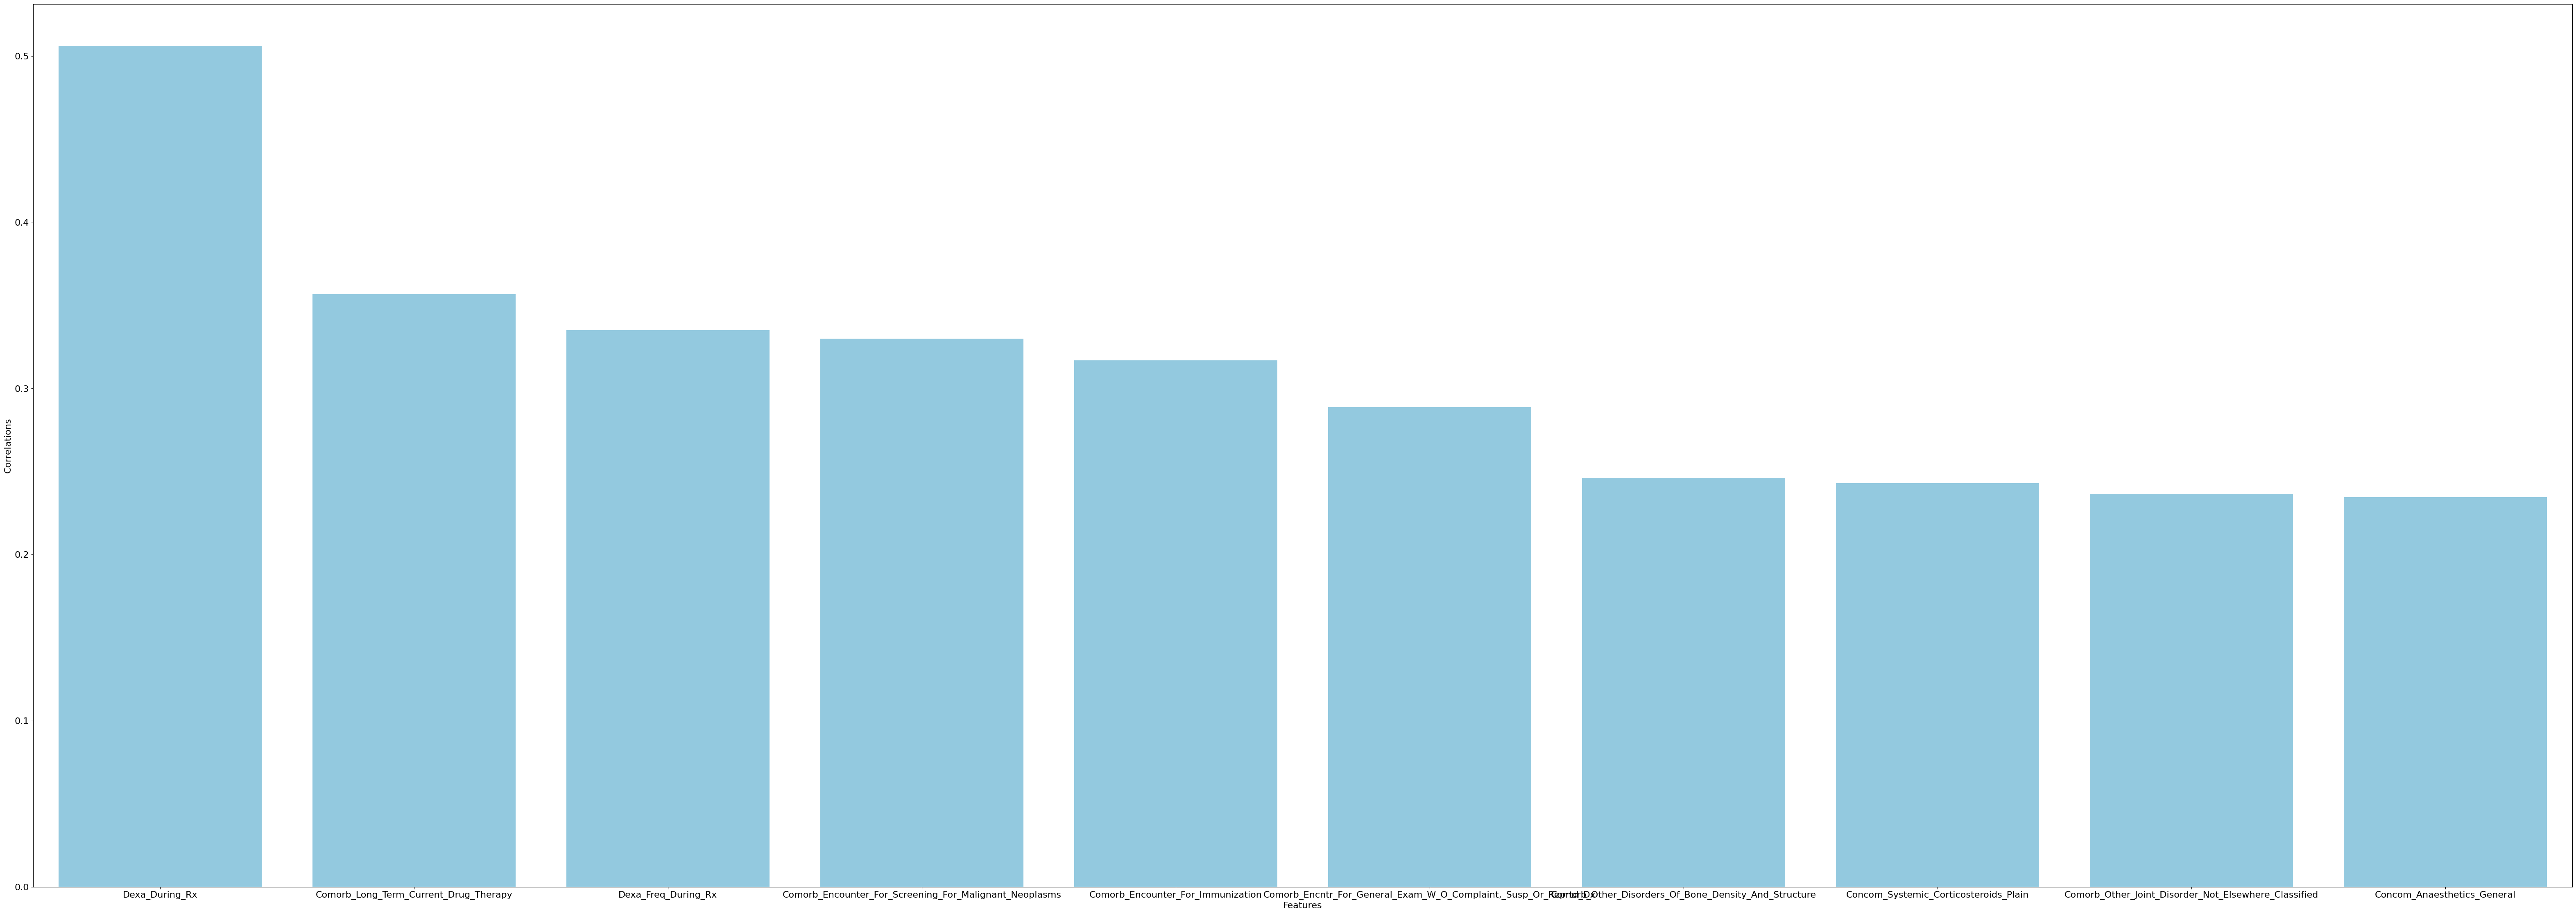

In [ ]:
# Sample data: categories and values
# Sample data: categories and values
fetauresGraph= []
for i in target_corr_val["Features"][:10]:
     fetauresGraph.append(i[1])

categories = fetauresGraph

values = target_corr_val["Correlation"][:10]

# Create a bar graph
plt.figure(figsize=(80, 28))
sns.barplot(x=categories, y=values, color='skyblue')

# Add labels and title
plt.xlabel('Features', fontsize=16)
plt.ylabel('Correlations', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

The following observations can be made:
* there are no features that are strongly positively/negatively correlated with a drug being Persistent
* there are 79 features that are neutrally correlated (near zero correlation)
  * drop these features

#### Modifying Based on correlations

In [ ]:
print(f'Shape before dropping: {df_clean.shape}')
# specifying features
nt_to_nt = ['Ntm_Speciality_RHEUMATOLOGY', 'Ntm_Specialist_Flag_Others'] # non-target to non-target strong positive correlation
drop_features = [pair[1] for pair in target_neut] # neutral correlation to target

# adding in nt_to_nt features, avoiding duplicates
for feat in nt_to_nt:
  if feat not in drop_features:
    drop_features.append(feat)

# dropping features
df_clean = df_clean.drop(columns=drop_features, axis=1)
print(f'Shape after dropping: {df_clean.shape}')
print(f'Features dropped: \n{drop_features}')
df_clean.head()

Shape before dropping: (3033, 123)
Shape after dropping: (3033, 43)
Features dropped: 
['Injectable_Experience_During_Rx', 'Risk_Segment_During_Rx_HR_VHR', 'Ntm_Speciality_ENDOCRINOLOGY', 'Count_Of_Risks', 'Risk_Vitamin_D_Insufficiency', 'Risk_Untreated_Chronic_Hypogonadism', 'Risk_Rheumatoid_Arthritis', 'Region_West', 'Risk_Chronic_Malnutrition_Or_Malabsorption', 'Ntm_Speciality_PATHOLOGY', 'Age_Bucket_65-75', 'Race_Asian', 'Ntm_Speciality_PEDIATRICS', 'Region_South', 'Region_Northeast', 'Tscore_Bucket_Prior_Ntm_>-2.5', 'Ntm_Speciality_OCCUPATIONAL MEDICINE', 'Ntm_Speciality_NUCLEAR MEDICINE', 'Ntm_Speciality_NEUROLOGY', 'Ntm_Speciality_RADIOLOGY', 'Risk_Chronic_Liver_Disease', 'Ethnicity_Not Hispanic', 'Risk_Segment_Prior_Ntm_VLR_LR', 'Region_Other/Unknown', 'Ntm_Speciality_PSYCHIATRY AND NEUROLOGY', 'Ntm_Speciality_HEMATOLOGY & ONCOLOGY', 'Ntm_Speciality_PLASTIC SURGERY', 'Ntm_Speciality_NEPHROLOGY', 'Ntm_Speciality_HOSPICE AND PALLIATIVE MEDICINE', 'Ntm_Speciality_VASCULAR SURGERY'

,Persistency_Flag,Dexa_Freq_During_Rx,Gluco_Record_During_Rx,Dexa_During_Rx,Frag_Frac_During_Rx,Idn_Indicator,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,...,Tscore_Bucket_During_Rx_>-2.5,Adherent_Flag_Adherent,Adherent_Flag_Non-Adherent,Ntm_Speciality_GENERAL PRACTITIONER,Ntm_Speciality_ONCOLOGY,Ntm_Speciality_Bucket_Endo/Onc/Uro,Ntm_Speciality_Bucket_OB/GYN/Others/PCP/Unknown,Change_T_Score_Improved,Change_T_Score_No change,Change_T_Score_Worsened
0,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0
2,0,0,0,0,0,0,1,0,1,0,...,0,1,0,1,0,0,1,0,1,0
3,0,0,1,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,0,1,0
4,0,0,1,0,0,0,1,1,1,0,...,0,1,0,1,0,0,1,0,1,0


#### Editing numerical preprocessors

If any of the numerical features were dropped, we must edit the pre-processors appropriately

In [ ]:
# checking if any of the previous numerical features were dropped
dropped_num_feats = []
new_num_feats = []
old_num_feats = pre_processing_log['num_feat']
for feat in drop_features:
  if feat in old_num_feats: # this feature was dropped
    dropped_num_feats.append(feat)


print(f'Dropped Numerical Features: {dropped_num_feats}')

# update the num_feats to not include the dropped features
new_num_feats = []
for feat in old_num_feats:
  if feat not in dropped_num_feats:
    new_num_feats.append(feat)

# updating pre_processing_log
pre_processing_log['num_feat'] = new_num_feats
num_features = pre_processing_log['num_feat']

print(f"New set of Numerical Features: {num_features}")

Dropped Numerical Features: ['Count_Of_Risks']
New set of Numerical Features: ['Dexa_Freq_During_Rx']


#### Min-Max Scaling (Normalization)

In [ ]:
# transformer for numerical data normalization
norm_transformer = Pipeline(steps=[('normalizer', MinMaxScaler())])
# creating normalization preprocessor
norm_preprocessor = ColumnTransformer(transformers=[('num_norm', norm_transformer, num_features)], remainder='passthrough')
# adding to pre_processing_log
pre_processing_log['norm'] = norm_preprocessor

#### Standard Scaling (Standardization)

In [ ]:
# transformer for numerical data standardization
std_transformer = Pipeline(steps=[('standardizer', StandardScaler())])
# creating standardization preprocessor
std_preprocessor = ColumnTransformer(transformers=[('num_standard', std_transformer, num_features)], remainder='passthrough')
# adding to pre_processing_log
pre_processing_log['std'] = std_preprocessor

#### Counting Split Between Target Classes

In [ ]:
# getting counts of each value in target column
target_val_counts = df_clean['Persistency_Flag'].value_counts()
print(f'Breakdown of Target (0 = Not_persistent, 1 = Persistent):\n{target_val_counts}')
print(f'Percent Persistent {target_val_counts[1]/len(df_clean["Persistency_Flag"])}')
print(f'Percent Non-Persistent: {target_val_counts[0]/len(df_clean["Persistency_Flag"])}')

Breakdown of Target (0 = Not_persistent, 1 = Persistent):
Persistency_Flag
0    1867
1    1166
Name: count, dtype: int64
Percent Persistent 0.38443785031322125
Percent Non-Persistent: 0.6155621496867788


Since the data is not evenly split the following assumptions can be made:
* if a predictor is set to always predict Non-Persistent (False or 0 in reference to our result mapping) it will perform presumably with and accuracy of 0.6156
* if a model performs above this mark, it can be deemed to be good learner

### Showing resultant pre-processors

In [ ]:
print(pre_processing_log)

{'num_feat': ['Dexa_Freq_During_Rx'], 'norm': ColumnTransformer(remainder='passthrough',
                  transformers=[('num_norm',
                                 Pipeline(steps=[('normalizer',
                                                  MinMaxScaler())]),
                                 ['Dexa_Freq_During_Rx'])]), 'std': ColumnTransformer(remainder='passthrough',
                  transformers=[('num_standard',
                                 Pipeline(steps=[('standardizer',
                                                  StandardScaler())]),
                                 ['Dexa_Freq_During_Rx'])])}


## Splitting Data

### X and y

In [ ]:
# isolating target
y = df_clean['Persistency_Flag']
# isolating inputs
X = df_clean.drop(columns=['Persistency_Flag'],axis=1)

print(f'y: {y.shape}')
print(f'X: {X.shape}')

y: (3033,)
X: (3033, 42)


### Training and Testing Data

In [ ]:
# specifying test_size
test_size=0.3
# splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)

print(f'Training Data \nX: {X_train.shape}\t y: {y_train.shape}')
print(f'Testing Data \nX: {X_test.shape}\t y: {y_test.shape}')

Training Data 
X: (2123, 42)	 y: (2123,)
Testing Data 
X: (910, 42)	 y: (910,)


### Training and Validation Data

In [ ]:
# specifying validation size
val_size = 0.1
# splitting data into training and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42, shuffle=True)

print(f'Training Data \nX: {X_tr.shape}\t y: {y_tr.shape}')
print(f'Validation Data \nX: {X_val.shape}\t y: {y_val.shape}')

Training Data 
X: (1910, 42)	 y: (1910,)
Validation Data 
X: (213, 42)	 y: (213,)


# Models

## General

Packages and Functions used by all model trainings

### General Packages

In [ ]:
# data pre-processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# model optimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### General Functions

In [ ]:
# fits model to data by running grid search, returns optmized model, optimized parameters, and best training score
# model_name: name of specific classifier being used
# grid: GridSearchCV(model, param_grid, cv, scoring) object
#       - model: is a Pipeline(steps=[preprocessing_steps, ('classifier', classifier)]) object that applies necessary pre-processing to data
#       - param_grid: dictionary where each pair is of form 'classifier__<parameter name>': [list of vals]
#       - cv: cross-validation value, default to 5
#       - scoring: scoring metric, default to 'accuracy'
# X: X data being trained on, this should be X_train
# y: y data being trained on, this should be y_train
def run_grid_search(model_name, grid, X, y):
    # fitting grid search
    print(f'Running Grid Search for {model_name}')
    grid.fit(X, y)
    print(f'Best Accuracy: {grid.best_score_}')
    print(f'Best Parameters: \n{grid.best_params_}')
    return grid.best_estimator_, grid.best_params_, grid.best_score_

In [ ]:
# takes in fitted model and return full evaluation report on model performance on testing data, returns predictions
# model: fitted model
# X: testing X data
# y: testing y data
def eval_report(model, X, y):
    # predicting on test data
    y_hat = model.predict(X)
    # reporting accuracy
    accuracy = accuracy_score(y, y_hat)
    print(f'Accuracy: {accuracy}')

    # reporting confusion matrix
    cf = confusion_matrix(y, y_hat)
    print('Confusion Matrix:')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks([0.5, 1.5], ['Non-Persistent', 'Persistent'])
    plt.yticks([0.5, 1.5], ['Non-Persistent', 'Persistent'], rotation=0)
    plt.title('Confusion Matrix')
    plt.show()

    # reporting classification report
    class_report = classification_report(y, y_hat, output_dict=True)
    print(f'Classification Report:')
    cr = pd.DataFrame(class_report).transpose()
    print(tabulate(cr, headers='keys', tablefmt='pretty'))

    # outputting predictions
    return y_hat, accuracy

In [ ]:
# pairs model weights with with feature name and returns paired list, helpter method for get_weights()
# weights: list of model weights
# feats: list of feature names for model that was trained (MUST BE IN SAME ORDER AS INPUTTED INTO MODEL FOR TRAINING)
def label_weights(weights, feats):
    # list of labeled weights of form (feature, weight)
    labeled_weights = []
    for feat, weight in zip(feats, weights):
        labeled_weights.append((feat,weight))
    return labeled_weights

# takes in fitted model and outputs fitted model weights with their associated features, if applicable
# model: fitted model
# feats: list of feature names for model that was trained (MUST BE IN SAME ORDER AS INPUTTED INTO MODEL FOR TRAINING)
# NOTE: NUMBER OF MODEL WEIGHTS AND FEATURES MUST MATCH
def get_weights(model, feats):
    # stores pairs of feature names
    # has two forms
    # - non-neural networks: [(feature, weight), ...]
    # - neural networks: [(input feature, weight, first hidden layer neuron number), ...], only covers input layer
    labeled_weights = None

    # linear model
    if hasattr(model, 'coef_'):
        # getting weights
        weights = model.coef_
        # assigning features to each weight
        labeled_weights = label_weights(weights.flatten(), feats)
    # decision tree and ensemble methods
    elif hasattr(model, 'feature_importances_'):
        # getting weights
        weights = model.feature_importances_
        # assigning features to each weight
        labeled_weights = label_weights(weights.flatten(), feats)
    # outputting labeled_weights
    return labeled_weights

# takes in labeled_weights array and returns it sorted in descending or ascending order
# SORTING IS DETERMINED BASED ON MAGNITUDE OF FEATURE WEIGHT
# labeled_weights: array returned by get_weights() function
# descending: boolean to determine whether it will be sorted in descending order, True = descending, False = ascending
def sort_labeled_weights(labeled_weights, descending=True):
    # returning sorted based on weights magnitude
    return sorted(labeled_weights, key=lambda x: abs(x[1]), reverse=True)

# takes in labeled weights and prints the first n weights
# sorted_labeled_weights: list of (feat, weight) tuples, result of sort_labeled_weights
# n: first n entries in list to display
def display_top_n_weights(sorted_labeled_weights, n):
    features, weights = zip(*sorted_labeled_weights[:n])
    organized = {'Features': features, 'Weights': weights}
    top_n = pd.DataFrame(organized)
    print(top_n.to_string())

### Logging Results
For evaluation and comparison at the end, after training our model we will save the information in a datastructure

In [ ]:
# datastructure to store the model
models_log = {}

'''
General structure of each entry

'model_name': trained_model_dictionary

trained_model_dictionary = {
    'model_name':,
    'fitted_model':,
    'best_parameters':,
    'training_accuacy':,
    'test_predictions':,
    'test_accuracy':,
    'labeled_final_weights':,
    'sorted_labeled_weights':,
}

abstracted out this can be simply viewed as
'model_name': trained_model_dictionary

'''

"\nGeneral structure of each entry\n\n'model_name': trained_model_dictionary\n\ntrained_model_dictionary = {\n    'model_name':,\n    'fitted_model':,\n    'best_parameters':,\n    'training_accuacy':,\n    'test_predictions':,\n    'test_accuracy':,\n    'labeled_final_weights':,\n    'sorted_labeled_weights':,\n}\n\nabstracted out this can be simply viewed as\n'model_name': trained_model_dictionary\n\n"

In [ ]:
# updated the models_log with newly trained model information
# models_log: dictionary being updated, stores information of all trained models
# model_name: name of trained model being added
# trained_model_dictionary: dictionary containing the following information
# {
#     'model_name':,
#     'fitted_model':,
#     'best_parameters':,
#     'training_accuacy':,
#     'test_predictions':,
#     'test_accuracy':,
#     'labeled_final_weights':,
#.    'sorted_labeled_weights':,
# }
def update_model_log(models_log, model_name, trained_model_dictionary):
    models_log[model_name] = trained_model_dictionary
    print(f'New entry {model_name} added to models_log, number of trained models = {len(list(models_log.keys()))}')

## K Nearest Neighbors

### Loading Packages

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Instantiating Model Training Info

In [ ]:
# getting appropriate preprocessor for numerical data
kn_preprocessor = pre_processing_log['norm']

# instantiating KNN classifier
knc = KNeighborsClassifier()

# instantiating pipeline for model training: numerical pre-processing --> classification model
knn_model = Pipeline(steps=[('preprocessor',kn_preprocessor),('classifier', knc)])

# defining list of neighbors
neighbors = list(range(2,21))

# defining parameter grid for GridSearchCV
knn_param_grid = {
    'classifier__n_neighbors': neighbors, # number of neighbors
    'classifier__weights': ['uniform','distance'], # weight function used in prediction
    'classifier__p': [1,2], # Power parameter for Minkowski metric
}

# instantiating GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
knn_grid = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy')

### Optimizing Model - HyperParameter Tuning
Running the model using GridSearchCV() on X_tr/y_tr, using X_val/y_val as the testing set

Steps:
* Run grid search on X_tr and y_tr to find best parameters (hyper-parameter tuning)
* calculate accuracy on X_val and y_val
* train the model with tuned hyper-parameters on X_train/y_train
  * this model and it's weights will be used as the final model, and will be evaluated on X_test/y_test

#### Elbow Method

In [ ]:
# runs elbow method and reports validation accuracy for each k value, returns best model, k, and accuracy
# model: defined knn model, is a Pipeline() object
# n_neighbors: array of integers representing each number of neighbors
# X_tr: training X data
# y_tr: training y data
# X_val: validation X data
# y_val: validation y data
def run_elbow(model, n_neighbors, X_tr, y_tr, X_val, y_val):
    # # variables to store best results
    # best_model = None
    # best_accuracy = 0
    # best_k = None
    models = [] # stores trained models
    # history of accuracies, ks, and losses for elbow plot
    accuracies = []
    losses = []
    ks = []

    # training on each k value
    for k in n_neighbors:
        # setting k
        model.set_params(classifier__n_neighbors=k)

        # fit on training data
        model.fit(X_tr, y_tr)
        # evaluating on validation dataset
        y_hat = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_hat)
        loss = 1 - accuracy

        # adding accuracy
        accuracies.append(accuracy)
        # adding loss
        losses.append(loss)
        # adding k value
        ks.append(k)
        # adding current trained model
        models.append(model)

        # # updating and storing if current model is best
        # if accuracy > best_accuracy:
        #     best_accuracy = accuracy
        #     best_model = model
        #     best_k = k

    # plotting accuracy agianst number of neighbors
    plt.plot(neighbors, losses, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Loss (1 - accuracy)')
    plt.title('Number of Neighbors vs Loss')
    plt.xticks(neighbors)
    plt.show()

    # combining into tuple list of form (model, k, accuracy, loss)
    results = list(zip(models, ks, accuracies, losses))

    # return best_model, best_accuracy, best_k
    return results

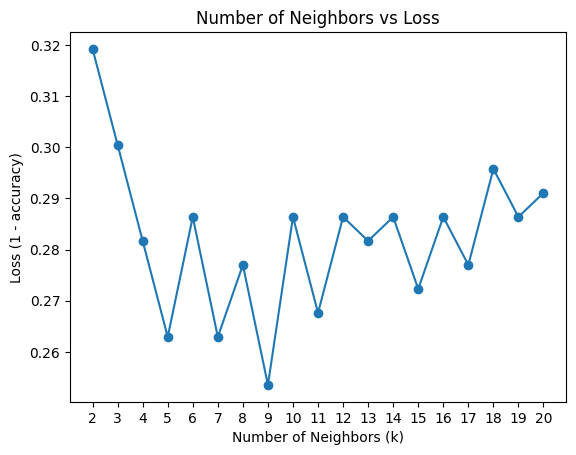

In [ ]:
# running elbow method to determine a k value
elbow_results = run_elbow(knn_model, neighbors, X_tr, y_tr, X_val, y_val)

Based upon the eblow method, the ideal number of neighbors to use is 5.  
We will now train a KNN Classifier with k=5 on the entire training dataset.  
We will also attempt to find the best KNN Classifier using GridSearchCV and compare their performances on the .

#### Grid-Search

In [ ]:
# running grid search
best_knn_grid, best_knn_grid_params, knn_training_score = run_grid_search('K Nearest Neighbors', knn_grid, X_tr, y_tr)

Running Grid Search for K Nearest Neighbors
Best Accuracy: 0.7717277486910995
Best Parameters: 
{'classifier__n_neighbors': 15, 'classifier__p': 1, 'classifier__weights': 'uniform'}


#### Evaluating on Training and Validation Set

Accuracy: 0.7089201877934272
Confusion Matrix:


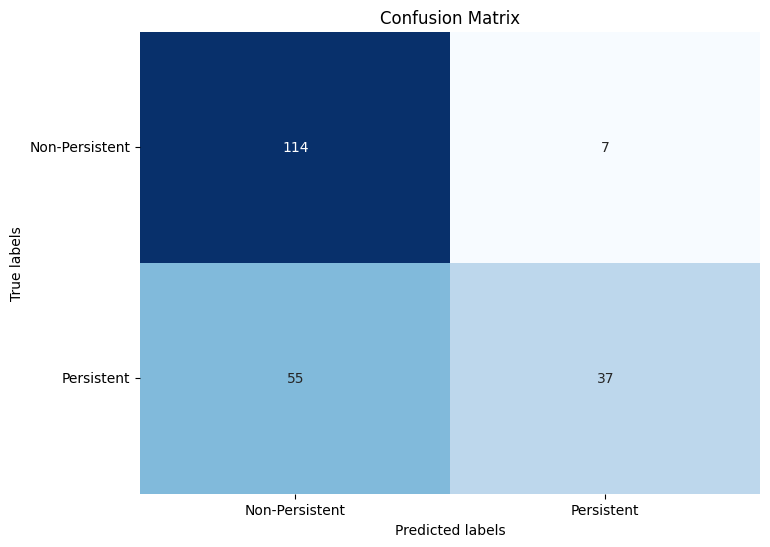

Classification Report:
+--------------+--------------------+---------------------+--------------------+--------------------+
|              |     precision      |       recall        |      f1-score      |      support       |
+--------------+--------------------+---------------------+--------------------+--------------------+
|      0       | 0.6745562130177515 | 0.9421487603305785  | 0.7862068965517243 |       121.0        |
|      1       | 0.8409090909090909 | 0.40217391304347827 | 0.5441176470588235 |        92.0        |
|   accuracy   | 0.7089201877934272 | 0.7089201877934272  | 0.7089201877934272 | 0.7089201877934272 |
|  macro avg   | 0.7577326519634212 | 0.6721613366870284  | 0.6651622718052739 |       213.0        |
| weighted avg | 0.7464081602759826 | 0.7089201877934272  | 0.6816425258787342 |       213.0        |
+--------------+--------------------+---------------------+--------------------+--------------------+


In [ ]:
# getting info from elbow k = 5
knn_elbow_model, k, elbow_acc, elbow_loss = elbow_results[3]
# evaluating results from elbow
knn_elbow_val_y_hat, knn_elbow_val_acc = eval_report(knn_elbow_model, X_val, y_val)

Evaluating Results from Grid KNN
Accuracy: 0.7276995305164319
Confusion Matrix:


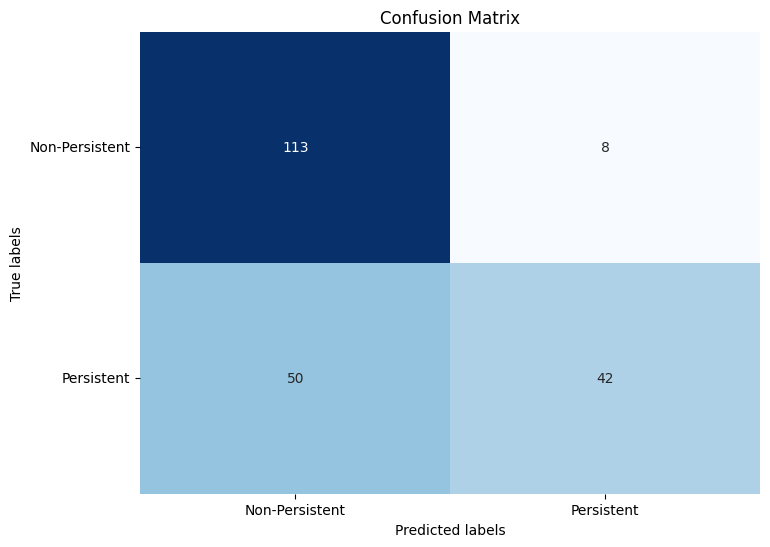

Classification Report:
+--------------+--------------------+---------------------+--------------------+--------------------+
|              |     precision      |       recall        |      f1-score      |      support       |
+--------------+--------------------+---------------------+--------------------+--------------------+
|      0       | 0.6932515337423313 | 0.9338842975206612  | 0.7957746478873239 |       121.0        |
|      1       |        0.84        | 0.45652173913043476 | 0.5915492957746479 |        92.0        |
|   accuracy   | 0.7276995305164319 | 0.7276995305164319  | 0.7276995305164319 | 0.7276995305164319 |
|  macro avg   | 0.7666257668711656 |  0.695203018325548  | 0.6936619718309859 |       213.0        |
| weighted avg | 0.7566358478066766 | 0.7276995305164319  | 0.7075646366461681 |       213.0        |
+--------------+--------------------+---------------------+--------------------+--------------------+


In [ ]:
# evaluating grid results on validation set
print(f'Evaluating Results from Grid KNN')
knn_val_y_hat, knn_val_acc = eval_report(best_knn_grid, X_val, y_val)

#### Training on Entire Test Dataset with tuned hyper-parameters

In [ ]:
# ELBOW METHOD PARAMS
# setting k
knn_model.set_params(classifier__n_neighbors=5)
# training classifier on entire training dataset
best_knn_elbow = knn_model.fit(X_train, y_train)

In [ ]:
# GRID SEARCH METHOD PARAMS
# making final model using tuned hyper-parameters and X_train, y_train
knn_final = Pipeline(steps=[
    ('preprocessor', kn_preprocessor),
    ('classifier', KNeighborsClassifier())
])
# setting parameters for final model
knn_final.set_params(**best_knn_grid_params)
# fitting on training data
knn_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_norm',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=15, p=1))])

### Evaluating Optimized Model

Evaluating Results from Elbow KNN
Accuracy: 0.7802197802197802
Confusion Matrix:


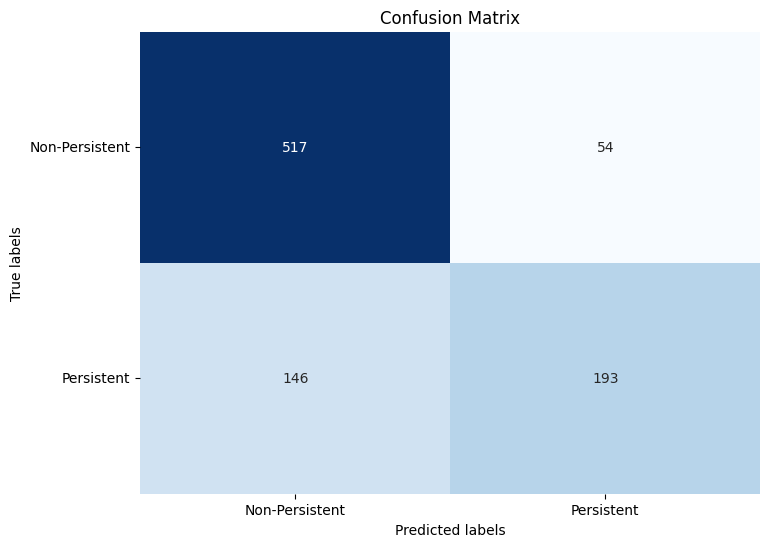

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.779788838612368  | 0.9054290718038529 | 0.8379254457050244 |       571.0        |
|      1       | 0.7813765182186235 | 0.5693215339233039 | 0.658703071672355  |       339.0        |
|   accuracy   | 0.7802197802197802 | 0.7802197802197802 | 0.7802197802197802 | 0.7802197802197802 |
|  macro avg   | 0.7805826784154958 | 0.7373753028635783 | 0.7483142586886897 |       910.0        |
| weighted avg | 0.7803802928832698 | 0.7802197802197802 | 0.7711601876862607 |       910.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# evaluating elbow results
print(f'Evaluating Results from Elbow KNN')
elbow_y_hat_knn, elbow_knn_accuracy = eval_report(best_knn_elbow, X_test, y_test)

Evaluating Results from Grid-Search KNN
Accuracy: 0.7901098901098901
Confusion Matrix:


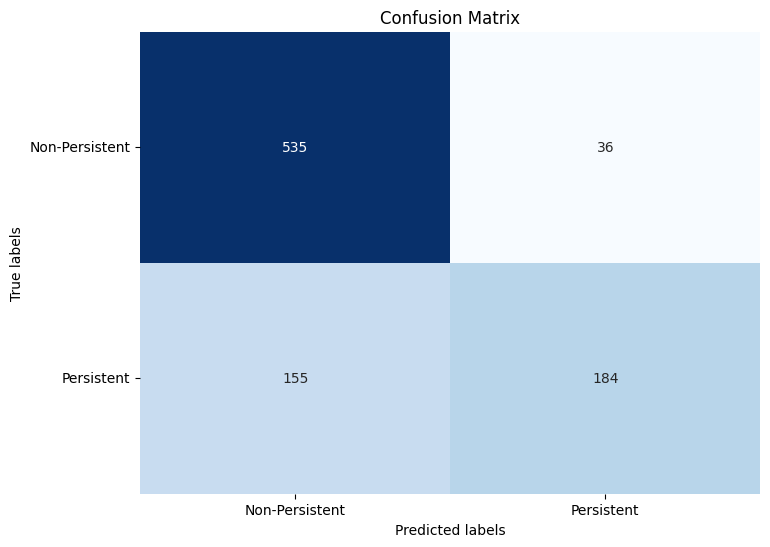

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.7753623188405797 | 0.9369527145359019 | 0.8485329103885805 |       571.0        |
|      1       | 0.8363636363636363 | 0.5427728613569321 | 0.6583184257602862 |       339.0        |
|   accuracy   | 0.7901098901098901 | 0.7901098901098901 | 0.7901098901098901 | 0.7901098901098901 |
|  macro avg   | 0.805862977602108  | 0.739862787946417  | 0.7534256680744333 |       910.0        |
| weighted avg | 0.7980869854782898 | 0.7901098901098901 | 0.7776727891918862 |       910.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# evaluating GridSearchCV results
print(f'Evaluating Results from Grid-Search KNN')
final_y_hat_knn, final_knn_accuracy = eval_report(knn_final, X_test, y_test)

#### Adding Trained Models to Log

In [ ]:
# recording results of elbow_knn model training
knn_elbow_result = {
    'model_name': 'knn_elbow',
    'fitted_model': best_knn_elbow,
    'best_params': best_knn_elbow.named_steps['classifier'].get_params(),
    'training_accuracy': knn_elbow_val_acc,
    'test_predictions': elbow_y_hat_knn,
    'test_accuracy': elbow_knn_accuracy,
    'labeled_final_weights': None,
    'sorted_labeled_weights': None,
}
# adding elbow_knn results
update_model_log(models_log, 'knn_elbow', knn_elbow_result)

# recording results of knn_grid model training
knn_result = {
    'model_name': 'knn',
    'fitted_model': knn_final,
    'best_params': best_knn_grid_params,
    'training_accuracy': knn_val_acc,
    'test_predictions': final_y_hat_knn,
    'test_accuracy': final_knn_accuracy,
    'labeled_final_weights': None,
    'sorted_labeled_weights': None,
}
# adding elbow_knn results
update_model_log(models_log, 'knn', knn_result)

New entry knn_elbow added to models_log, number of trained models = 1
New entry knn added to models_log, number of trained models = 2


## Naive Bayes

### Loading Packages

In [ ]:
from sklearn.naive_bayes import CategoricalNB

Ways to deal with our Mixed continuous and categorical data  
* https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea
* https://pypi.org/project/mixed-naive-bayes/
* https://medium.com/analytics-vidhya/naive-bayes-for-mixed-typed-data-in-scikit-learn-fb6843e241f0

__Approach__:  
Since there is only have 1 numerical feature, convert it into a categorical representation and then One-Hot encode

In [ ]:
# make this into function converts the numerical data into categorical representation for naive bayes classifier
# X: dataframe
# numerical_features: list of numerical features
# num_feat_pp: appropraite-pre-processor for numerical data
def naive_bayes_preprocessing(X):
    # copy dataframe
    XC = X.copy()
    # instantiating scaler
    scaler = StandardScaler()

    # standardizing 'Dexa_Freq_During_Rx
    feature_values = XC["Dexa_Freq_During_Rx"].values.reshape(-1, 1)
    scaledVal = scaler.fit_transform(feature_values)
    XC["Dexa_Freq_During_Rx"] = scaledVal.ravel()

    # categorical labeling 'Dexa_Freq_During_Rx'
    Dexa_Freq = []
    for i in XC["Dexa_Freq_During_Rx"]:
        if i > -.5 and i <= 0 :
            Dexa_Freq.append("No Occurance")
        elif i > 0  and i <= .11:
            Dexa_Freq.append("1-4 Occurance")
        elif i > .11:
            Dexa_Freq.append("Over 4 Occurance")
    XC["Dexa_Freq_During_Rx"] = Dexa_Freq

    return XC

### Instantiating Model Training Info

In [ ]:
# converting numerical features into one-hot encoded categorical representation for Naive Bayes
XC_train = naive_bayes_preprocessing(X_train)
XC_test = naive_bayes_preprocessing(X_test)
XC_val = naive_bayes_preprocessing(X_val)
XC_tr = naive_bayes_preprocessing(X_tr)

In [ ]:
# columns to one-hot encode
to_oh_columns = ['Dexa_Freq_During_Rx']

# make preprocessor
nb_preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), to_oh_columns)], remainder='passthrough')

# instantiating Naive Bayes Classifier
nbb = BernoulliNB() # since all of our data is One-Hot Encoded

# instantiating pipeline for model training
nb_model = Pipeline(steps=[('preprocessor',nb_preprocessor),('classifier', nbb)])

# defining parameter grid for GridSearchCV
nb_param_grid = {
    'classifier__alpha': [0.1, 1.0, 10, 100],
    'classifier__fit_prior': [True, False],
 }

# instantiating GridSearchCV
nb_grid = GridSearchCV(nb_model, nb_param_grid, cv=5, scoring='accuracy')

### Optimizing Model

#### Hyper-Parameter Tuning

In [ ]:
# filter warnings
suppress_warning([FitFailedWarning, UserWarning])
# running grid search
best_nb, best_nb_params, nb_training_score = run_grid_search('Naive Bayes', nb_grid, XC_tr, y_tr)

Running Grid Search for Naive Bayes
Best Accuracy: 0.8109947643979056
Best Parameters: 
{'classifier__alpha': 10, 'classifier__fit_prior': True}


Accuracy: 0.7981220657276995
Confusion Matrix:


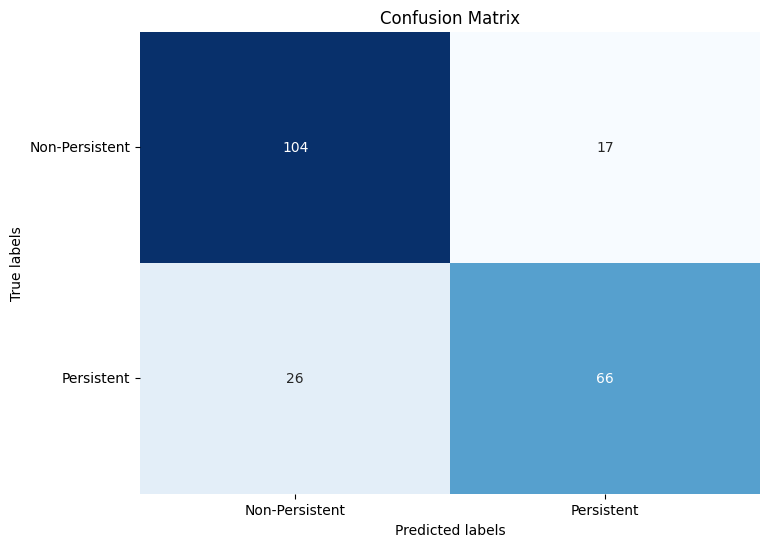

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       |        0.8         | 0.859504132231405  | 0.8286852589641435 |       121.0        |
|      1       | 0.7951807228915663 | 0.717391304347826  | 0.7542857142857142 |        92.0        |
|   accuracy   | 0.7981220657276995 | 0.7981220657276995 | 0.7981220657276995 | 0.7981220657276995 |
|  macro avg   | 0.7975903614457831 | 0.7884477182896155 | 0.7914854866249288 |       213.0        |
| weighted avg | 0.7979184343005827 | 0.7981220657276995 | 0.796550244361254  |       213.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on validation data
nb_val_y_hat, nb_val_acc = eval_report(best_nb, XC_val, y_val)

#### Training on Entire Test Dataset with tuned hyper-parameters

In [ ]:
# making final model using tuned hyper-parameters and X_train, y_train
nb_final = Pipeline(steps=[
    ('preprocessor', nb_preprocessor),
    ('classifier', BernoulliNB())
])
# setting parameters for final model
nb_final.set_params(**best_nb_params)
# fitting on training data
nb_final.fit(XC_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier', BernoulliNB(alpha=10))])

### Evaluating Optimized Model

Accuracy: 0.8142857142857143
Confusion Matrix:


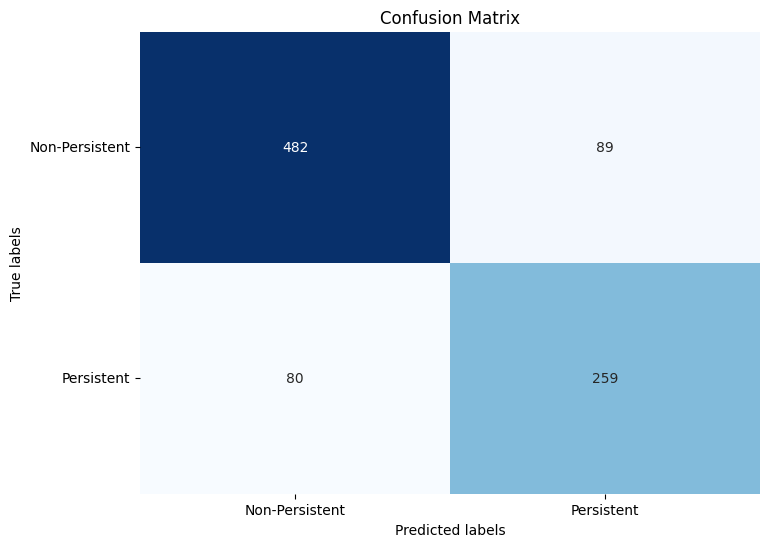

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.8576512455516014 | 0.8441330998248686 | 0.8508384819064431 |       571.0        |
|      1       | 0.7442528735632183 | 0.7640117994100295 | 0.7540029112081513 |       339.0        |
|   accuracy   | 0.8142857142857143 | 0.8142857142857143 | 0.8142857142857143 | 0.8142857142857143 |
|  macro avg   | 0.8009520595574099 | 0.8040724496174491 | 0.8024206965572972 |       910.0        |
| weighted avg | 0.815407236646039  | 0.8142857142857143 | 0.8147645715034532 |       910.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on test data
y_hat_nb, accuracy_nb = eval_report(nb_final, XC_test, y_test)

#### Getting feature importance

No weights due to Naive Bayes having no weights with Catergorical data

#### Adding Trained Models to Log

In [ ]:
# recording results of naive bayes model training
nb_results = {
    'model_name': 'naive_bayes',
    'fitted_model': nb_final,
    'best_params': best_nb_params,
    'training_accuracy': nb_val_acc,
    'test_predictions': y_hat_nb,
    'test_accuracy': accuracy_nb,
    'labeled_final_weights': None,
    'sorted_labeled_weights': None,
}
# adding naive bayes results
update_model_log(models_log, 'naive_bayes', nb_results)

New entry naive_bayes added to models_log, number of trained models = 3


## Decision Tree

### Loading Packages

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### Instantiating Model Training Info

In [ ]:
# getting appropriate preprocessor for numerical data
dt_preprocessor = pre_processing_log['std']
# make any additional preprocessors

# instantiating Decision Tree Classifier
dtc = DecisionTreeClassifier()

# instantiating pipeline for model training
dt_model = Pipeline(steps=[('preprocessor',dt_preprocessor),('classifier', dtc)])

# defining parameter grid for GridSearchCV
dt_param_grid = {
    'classifier__criterion': ['entropy'], # C5.0 uses entropy for splitting criterion
    'classifier__splitter': ['best'], # picking splitting feature
    'classifier__min_samples_split': [1,2,3,4,5], # min number of samples to split a node
    'classifier__min_samples_leaf': [1,2,5], # min number of observations in a leaf
    'classifier__random_state': [8],
}

# instantiating GridSearchCV
dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=5, scoring='accuracy')

### Optimizing Model

#### Hyper-Parameter Tuning

In [ ]:
# filter warnings
suppress_warning([FitFailedWarning, UserWarning])
# running grid search
best_dt, best_dt_params, dt_training_score = run_grid_search('Decision Tree', dt_grid, X_tr, y_tr)

Running Grid Search for Decision Tree
Best Accuracy: 0.7638743455497382
Best Parameters: 
{'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__random_state': 8, 'classifier__splitter': 'best'}


Accuracy: 0.7323943661971831
Confusion Matrix:


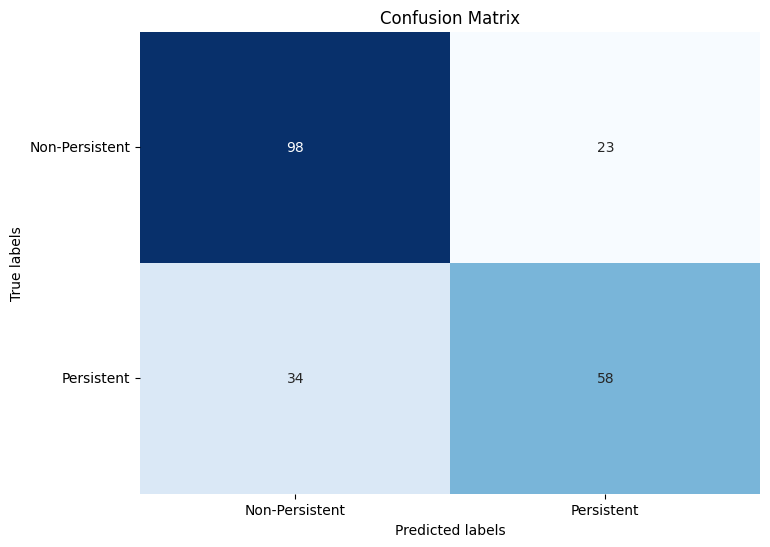

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.7424242424242424 | 0.8099173553719008 | 0.774703557312253  |       121.0        |
|      1       | 0.7160493827160493 | 0.6304347826086957 | 0.6705202312138728 |        92.0        |
|   accuracy   | 0.7323943661971831 | 0.7323943661971831 | 0.7323943661971831 | 0.7323943661971831 |
|  macro avg   | 0.7292368125701458 | 0.7201760689902983 | 0.7226118942630629 |       213.0        |
| weighted avg | 0.731032284240422  | 0.7323943661971831 | 0.7297041864153001 |       213.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on validation data
dt_val_y_hat, dt_val_acc = eval_report(best_dt, X_val, y_val)

#### Training on Entire Test Dataset with Tuneded Hyper-Parameters

In [ ]:
# making final model using tuned hyper-parameters and X_train, y_train
dt_final = Pipeline(steps=[
    ('preprocessor', dt_preprocessor),
    ('classifier', DecisionTreeClassifier())
])
# setting parameters for final model
dt_final.set_params(**best_dt_params)
# fitting on training data
dt_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5,
                                        random_state=8))])

### Evaluating Optimized Model

Accuracy: 0.7736263736263737
Confusion Matrix:


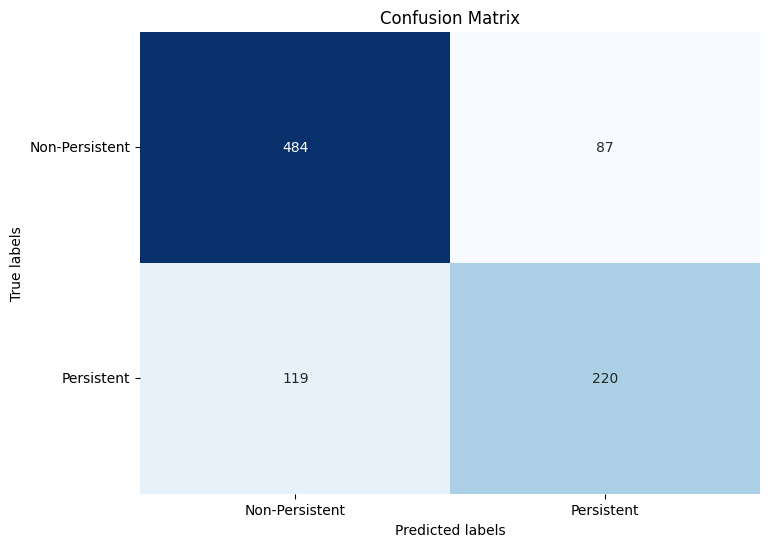

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.802653399668325  | 0.8476357267950964 | 0.8245315161839863 |       571.0        |
|      1       | 0.7166123778501629 | 0.6489675516224189 | 0.6811145510835913 |       339.0        |
|   accuracy   | 0.7736263736263737 | 0.7736263736263737 | 0.7736263736263737 | 0.7736263736263737 |
|  macro avg   | 0.759632888759244  | 0.7483016392087576 | 0.7528230336337889 |       910.0        |
| weighted avg | 0.770600755276724  | 0.7736263736263737 | 0.7711047566575754 |       910.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on test data
y_hat_dt, accuracy_dt = eval_report(dt_final, X_test, y_test)

#### Getting Feature Importance for Logistic Regression

In [ ]:
# getting labeleing model weights
dt_l_w = get_weights(best_dt.named_steps['classifier'], X_train.columns)
# getting model weights sorted in descending magnitutde order
dt_l_w_sort = sort_labeled_weights(dt_l_w)

In [ ]:
# displaying top n weights
display_top_n_weights(dt_l_w_sort, 20)

                                                           Features   Weights
0                                               Dexa_Freq_During_Rx  0.372456
1                                 Comorb_Encounter_For_Immunization  0.078817
2                             Comorb_Long_Term_Current_Drug_Therapy  0.058601
3   Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx  0.035541
4                                       Comorb_Vitamin_D_Deficiency  0.028533
5                                           Concom_Fluoroquinolones  0.022954
6       Concom_Cholesterol_And_Triglyceride_Regulating_Preparations  0.022678
7                               Concom_Macrolides_And_Similar_Types  0.022651
8            Comorb_Encounter_For_Screening_For_Malignant_Neoplasms  0.022164
9          Comorb_Personal_History_Of_Other_Diseases_And_Conditions  0.021610
10                               Ntm_Speciality_Bucket_Endo/Onc/Uro  0.021480
11  Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidem

#### Adding Trained Models to Log

In [ ]:
# recording results of Decision Tree model training
dt_result = {
    'model_name': 'decision_tree',
    'fitted_model': dt_final,
    'best_params': best_dt_params,
    'training_accuracy': dt_val_acc,
    'test_predictions': y_hat_dt,
    'test_accuracy': accuracy_dt,
    'labeled_final_weights': dt_l_w,
    'sorted_labeled_weights': dt_l_w_sort,
}
# adding Decision Tree results
update_model_log(models_log, 'decision_tree', dt_result)

New entry decision_tree added to models_log, number of trained models = 4


## CART

### Loading Packages

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### Instantiating Model Training Info

In [ ]:
# gettting appropriate preprocessor for numerical data
CART_preprocessor = pre_processing_log['std']

# Instantiate DecisionTreeClassifier
Cart = DecisionTreeClassifier()

# Instantiating pipeline for model training
Cart_model = Pipeline(steps=[('preprocessor',CART_preprocessor),('classifier', Cart)])

# Defining parameter grid for GridSearchCV
CART_param_grid = {
    'classifier__criterion': ['gini'], # CART uses gini for splitting criterion
    'classifier__min_samples_split': [1,2,3,4,5],
    'classifier__min_samples_leaf': [1,2,5],
}

# Instantiating GridSearchCV
CART_grid = GridSearchCV(Cart_model, CART_param_grid, cv=5, scoring='accuracy')

### Optimizing Model

#### Hyper-Parameter Tuning

In [ ]:
# running grid search
best_CART, best_CART_params, CART_training_score = run_grid_search('CART', CART_grid, X_tr, y_tr)

Running Grid Search for CART
Best Accuracy: 0.7717277486910994
Best Parameters: 
{'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 3}


Accuracy: 0.7464788732394366
Confusion Matrix:


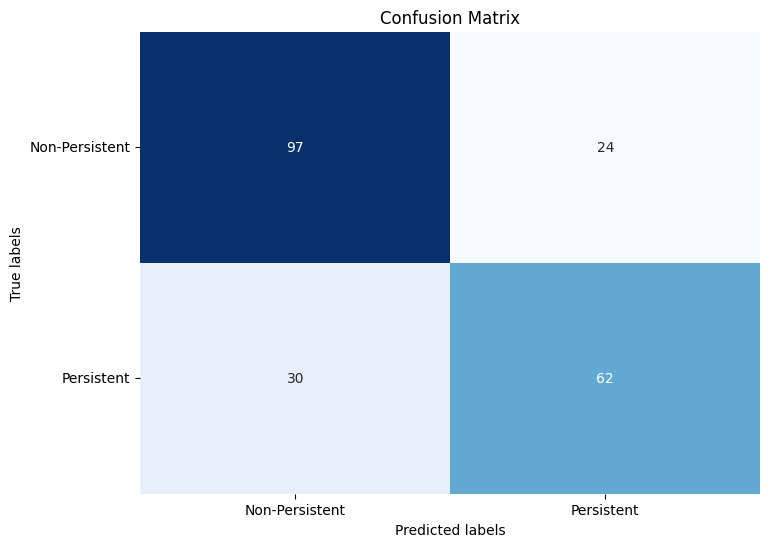

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.7637795275590551 | 0.8016528925619835 | 0.7822580645161291 |       121.0        |
|      1       | 0.7209302325581395 | 0.6739130434782609 | 0.6966292134831461 |        92.0        |
|   accuracy   | 0.7464788732394366 | 0.7464788732394366 | 0.7464788732394366 | 0.7464788732394366 |
|  macro avg   | 0.7423548800585973 | 0.7377829680201222 | 0.7394436389996376 |       213.0        |
| weighted avg | 0.7452718508450447 | 0.7464788732394366 | 0.7452728330840426 |       213.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on validation data
CART_val_y_hat, CART_val_acc = eval_report(best_CART, X_val, y_val)

#### Training on Entire Test Dataset with tuned hyper-parameters

In [ ]:
# making final model using tuned hyper-parameters and X_train, y_train
CART_final = Pipeline(steps=[
    ('preprocessor', CART_preprocessor),
    ('classifier', DecisionTreeClassifier())
])
# setting parameters for final model
CART_final.set_params(**best_CART_params)
# fitting on training data
CART_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier',
                 DecisionTreeClassifier(min_samples_leaf=5,
                                        min_samples_split=3))])

### Evaluating Optimized Model

Accuracy: 0.7494505494505495
Confusion Matrix:


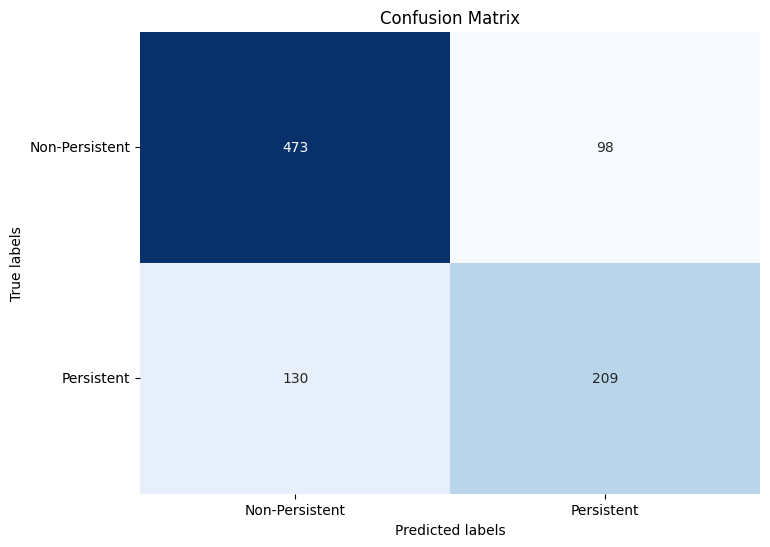

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.7844112769485904 | 0.8283712784588442 | 0.8057921635434413 |       571.0        |
|      1       | 0.6807817589576547 | 0.616519174041298  | 0.6470588235294118 |       339.0        |
|   accuracy   | 0.7494505494505495 | 0.7494505494505495 | 0.7494505494505495 | 0.7494505494505495 |
|  macro avg   | 0.7325965179531225 | 0.7224452262500711 | 0.7264254935364265 |       910.0        |
| weighted avg | 0.7458064345321869 | 0.7494505494505495 | 0.746659633582171  |       910.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on test data
y_hat_CART, accuracy_CART = eval_report(CART_final, X_test, y_test)

In [ ]:
# getting labeleing model weights
CART_l_w = get_weights(best_CART.named_steps['classifier'], X_train.columns)
# getting model weights sorted in descending magnitutde order
CART_l_w_sort = sort_labeled_weights(CART_l_w)

In [ ]:
display_top_n_weights(CART_l_w_sort, 20)

                                                           Features   Weights
0                                               Dexa_Freq_During_Rx  0.457685
1                                 Comorb_Encounter_For_Immunization  0.076947
2                             Comorb_Long_Term_Current_Drug_Therapy  0.057092
3   Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx  0.033426
4            Comorb_Encounter_For_Screening_For_Malignant_Neoplasms  0.024274
5                               Concom_Macrolides_And_Similar_Types  0.023773
6                                           Concom_Fluoroquinolones  0.020510
7          Comorb_Personal_History_Of_Other_Diseases_And_Conditions  0.019135
8                                    Ntm_Specialist_Flag_Specialist  0.018884
9                      Concom_Anti_Depressants_And_Mood_Stabilisers  0.018150
10                                                    Idn_Indicator  0.015813
11                                          Ntm_Speciality_ONCOL

#### Adding Trained Models to Log

In [ ]:
# recording results of CART model training
CART_result = {
    'model_name': "CART",
    'fitted_model': CART_final,
    'best_params': best_CART_params,
    'training_accuracy': CART_val_acc,
    'test_predictions': y_hat_CART,
    'test_accuracy': accuracy_CART,
    'labeled_final_weights': CART_l_w,
    'sorted_labeled_weights': CART_l_w_sort,
}
# adding CART results
update_model_log(models_log, "CART", CART_result)

New entry CART added to models_log, number of trained models = 5


## Random Forest

### Loading Packages

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Instantiating Model Training Info

In [ ]:
# getting appropriate preprocessor for numerical data
rf_preprocessor = pre_processing_log['std']
# make any additional preprocessors

# instantiating Random Forest Classifier
rfc = RandomForestClassifier()

# instantiating pipeline for model training
rf_model = Pipeline(steps=[('preprocessor',rf_preprocessor),('classifier', rfc)])

# defining parameter grid for GridSearchCV
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 150], # number of trees in forest
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__min_samples_split': [1,2,3,4,5], # min number of samples to split a node
    'classifier__min_samples_leaf': [1,2,5], # min number of observations in a leaf
    'classifier__random_state': [8],
}

# instantiating GridSearchCV
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy')

### Optimizing Model

Hyper-Parameter Tuning

In [ ]:
# filter warnings
suppress_warning([FitFailedWarning, UserWarning])
# running grid search
best_rf, best_rf_params, rf_training_score = run_grid_search('Random Forest', rf_grid, X_tr, y_tr)

Running Grid Search for Random Forest
Best Accuracy: 0.8157068062827225
Best Parameters: 
{'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'classifier__random_state': 8}


Accuracy: 0.7934272300469484
Confusion Matrix:


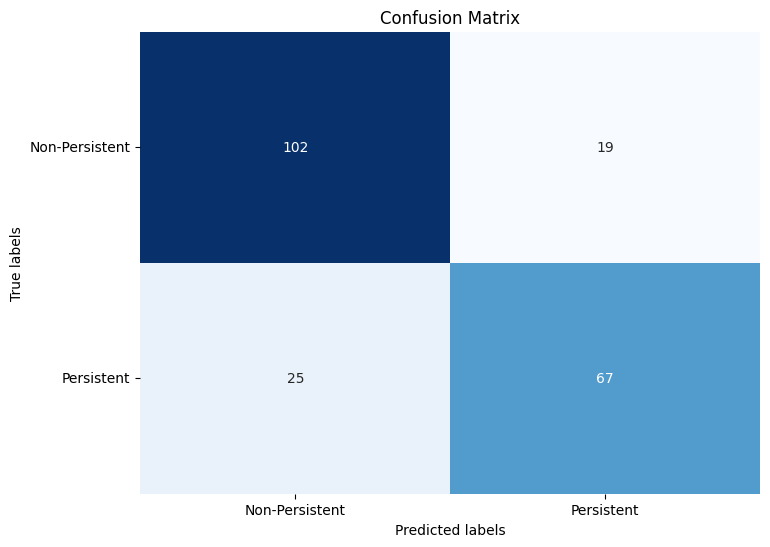

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.8031496062992126 | 0.8429752066115702 | 0.8225806451612903 |       121.0        |
|      1       | 0.7790697674418605 | 0.7282608695652174 | 0.7528089887640451 |        92.0        |
|   accuracy   | 0.7934272300469484 | 0.7934272300469484 | 0.7934272300469484 | 0.7934272300469484 |
|  macro avg   | 0.7911096868705365 | 0.7856180380883938 | 0.7876948169626676 |       213.0        |
| weighted avg | 0.792748924727023  | 0.7934272300469484 | 0.7924445306610717 |       213.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on validation data
rf_val_y_hat, rf_val_acc = eval_report(best_rf, X_val, y_val)

Training on Entire Test Dataset with Tuned Hyper-Paramters

In [ ]:
# making final model using tuned hyper-parameters and X_train, y_train
rf_final = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('classifier', RandomForestClassifier())
])
# setting parameters for final model
rf_final.set_params(**best_rf_params)
# fitting on training data
rf_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=5, random_state=8))])

### Evaluating Optimized Model

Accuracy: 0.798901098901099
Confusion Matrix:


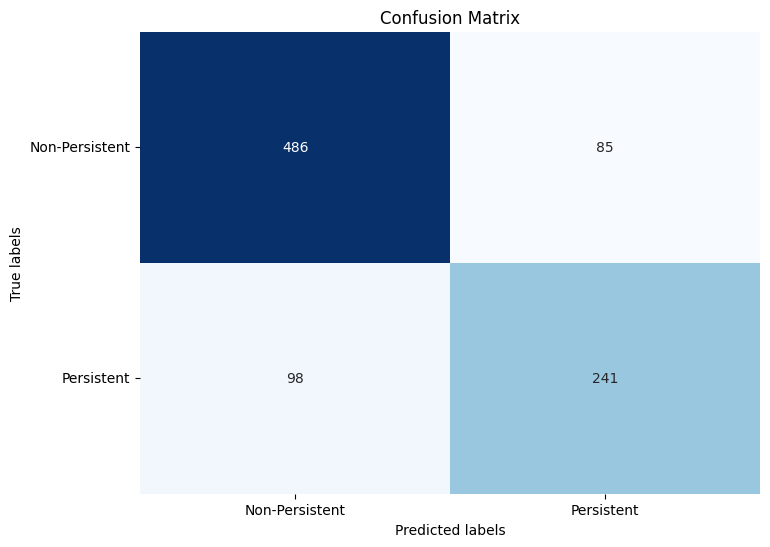

Classification Report:
+--------------+--------------------+--------------------+--------------------+-------------------+
|              |     precision      |       recall       |      f1-score      |      support      |
+--------------+--------------------+--------------------+--------------------+-------------------+
|      0       | 0.8321917808219178 | 0.851138353765324  | 0.8415584415584416 |       571.0       |
|      1       | 0.7392638036809815 | 0.7109144542772862 | 0.724812030075188  |       339.0       |
|   accuracy   | 0.798901098901099  | 0.798901098901099  | 0.798901098901099  | 0.798901098901099 |
|  macro avg   | 0.7857277922514496 | 0.7810264040213051 | 0.7831852358168148 |       910.0       |
| weighted avg | 0.7975735563705141 | 0.798901098901099  | 0.7980671959619329 |       910.0       |
+--------------+--------------------+--------------------+--------------------+-------------------+


In [ ]:
# predicting on test data
y_hat_rf, accuracy_rf = eval_report(rf_final, X_test, y_test)

#### Getting feature importance

In [ ]:
# getting labeleing model weights
rf_l_w = get_weights(best_rf.named_steps['classifier'], X_train.columns)
# getting model weights sorted in descending magnitutde order
rf_l_w_sort = sort_labeled_weights(rf_l_w)

In [ ]:
# displaying top n weights
display_top_n_weights(rf_l_w_sort, 20)

                                                              Features   Weights
0                                                  Dexa_Freq_During_Rx  0.139857
1                                                       Dexa_During_Rx  0.087428
2                                    Comorb_Encounter_For_Immunization  0.047929
3               Comorb_Encounter_For_Screening_For_Malignant_Neoplasms  0.047276
4                                Comorb_Long_Term_Current_Drug_Therapy  0.045722
5      Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx  0.039775
6                 Comorb_Other_Disorders_Of_Bone_Density_And_Structure  0.025881
7                                          Comorb_Vitamin_D_Deficiency  0.024380
8                 Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified  0.023323
9                                                        Idn_Indicator  0.021923
10                               Concom_Systemic_Corticosteroids_Plain  0.020897
11                          

#### Adding Trained Models to Log

In [ ]:
# recording results of Random Forest model training
rf_result = {
    'model_name': 'random_forest',
    'fitted_model': rf_final,
    'best_params': best_rf_params,
    'training_accuracy': rf_val_acc,
    'test_predictions': y_hat_rf,
    'test_accuracy': accuracy_rf,
    'labeled_final_weights': rf_l_w,
    'sorted_labeled_weights': rf_l_w_sort,
}
# adding Random Forest results
update_model_log(models_log, 'random_forest', rf_result)

New entry random_forest added to models_log, number of trained models = 6


## Support Vector Machine

### Loading Packages

In [ ]:
from sklearn.svm import SVC

### Instantiating Model Training Info

In [ ]:
# getting appropriate preprocessor for numerical data
svm_preprocessor = pre_processing_log['std']

# instantiating Support Vector Classifier
svc = SVC()

# instantiating pipeline for model training
svm_model = Pipeline(steps=[('preprocessor',svm_preprocessor),('classifier', svc)])

# defining parameter grid for GridSearchCV
svm_param_grid = {
    #since the best kernal isnt lenear then we can't get any weight.
    'classifier__kernel': ['linear','poly','rbf','sigmoid'],
    'classifier__degree': [2,3,4,5],
    'classifier__gamma': ['scale','auto'],
    'classifier__random_state': [8],
  }

# instantiating GridSearchCV
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy')

### Optimizing Model

#### Hyper-Parameter Tuning

In [ ]:
# running grid search
best_svm, best_svm_params, svm_training_score = run_grid_search('Support Vector Machine', svm_grid, X_tr, y_tr)

Running Grid Search for Support Vector Machine
Best Accuracy: 0.8104712041884816
Best Parameters: 
{'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'classifier__random_state': 8}


Accuracy: 0.7981220657276995
Confusion Matrix:


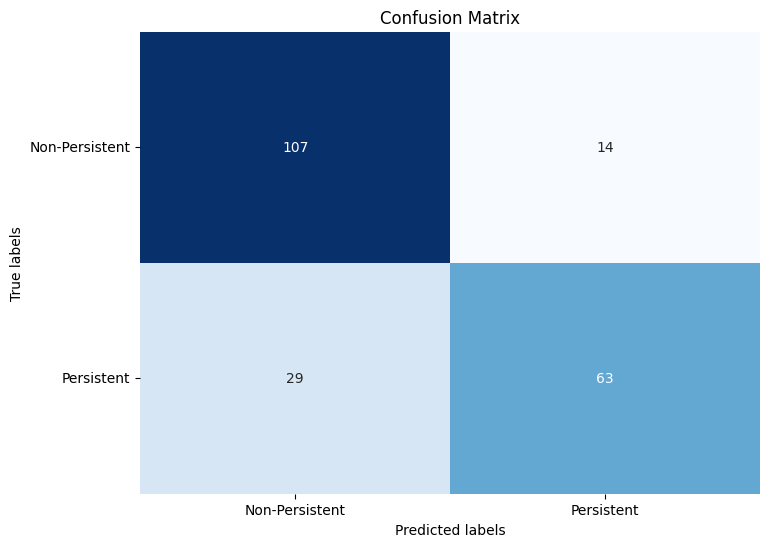

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.7867647058823529 | 0.8842975206611571 | 0.8326848249027237 |       121.0        |
|      1       | 0.8181818181818182 | 0.6847826086956522 | 0.7455621301775148 |        92.0        |
|   accuracy   | 0.7981220657276995 | 0.7981220657276995 | 0.7981220657276995 | 0.7981220657276995 |
|  macro avg   | 0.8024732620320856 | 0.7845400646784046 | 0.7891234775401192 |       213.0        |
| weighted avg | 0.8003345384248451 | 0.7981220657276995 | 0.7950543652092061 |       213.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on validation data
svm_val_y_hat, svm_val_acc = eval_report(best_svm, X_val, y_val)

#### Training on Entire Test Dataset with Tuned Hyper-parameters

In [ ]:
# making final model using tuned hyper-parameters and X_train, y_train
svm_final = Pipeline(steps=[
    ('preprocessor', svm_preprocessor),
    ('classifier', SVC())
])
# setting parameters for final model
svm_final.set_params(**best_svm_params)
# fitting on training data
svm_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier', SVC(degree=2, random_state=8))])

### Evaluating Optimized Model

Accuracy: 0.8065934065934066
Confusion Matrix:


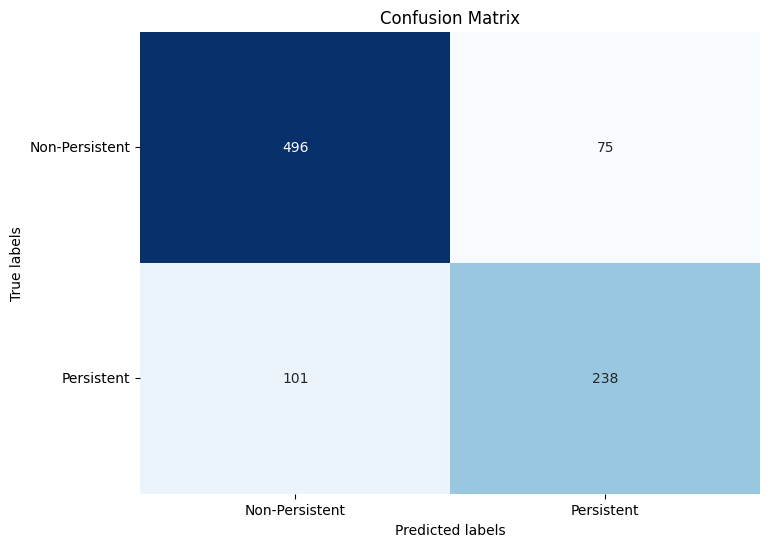

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.830820770519263  | 0.8686514886164624 | 0.8493150684931506 |       571.0        |
|      1       | 0.7603833865814696 | 0.7020648967551623 | 0.7300613496932515 |       339.0        |
|   accuracy   | 0.8065934065934066 | 0.8065934065934066 | 0.8065934065934066 | 0.8065934065934066 |
|  macro avg   | 0.7956020785503664 | 0.7853581926858123 | 0.7896882090932011 |       910.0        |
| weighted avg | 0.8045809099094696 | 0.8065934065934066 | 0.8048897820391223 |       910.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on test data
y_hat_svm, accuracy_svm = eval_report(svm_final, X_test, y_test)

#### Getting feature importance

Since there are no weights when kernel='rbf', feature importance cannot be determined

#### Adding Trained Models to Log

In [ ]:
# recording results of Support Vector Machine model training
svm_result = {
    'model_name': 'svm',
    'fitted_model': svm_final,
    'best_params': best_svm_params,
    'training_accuracy': svm_val_acc,
    'test_predictions': y_hat_svm,
    'test_accuracy': accuracy_svm,
    'labeled_final_weights': None,
    'sorted_labeled_weights': None,
}
# adding Support Vector Machine results
update_model_log(models_log, 'svm', svm_result)

New entry svm added to models_log, number of trained models = 7


## Stochastic Gradient Descent

### Loading Packages

In [ ]:
from sklearn.linear_model import SGDClassifier

### Instantiating Model Training Info

In [ ]:
# getting appropriate preprocessor for numerical data
sgd_preprocessor = pre_processing_log['std']

# instantiating Stochastic Gradient Descent Classifier
sgdc = SGDClassifier()

# instantiating pipeline for model training
sgd_model = Pipeline(steps=[('preprocessor',sgd_preprocessor),('classifier', sgdc)])

# defining parameter grid for GridSearchCV
sgd_param_grid = {
   'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__max_iter': [100, 500, 1000],
}

# instantiating GridSearchCV
sgd_grid = GridSearchCV(sgd_model, sgd_param_grid, cv=5, scoring='accuracy')

### Optimizing Model

#### Hyper-Parameter Tuning

In [ ]:
# filter warnings
suppress_warning([FitFailedWarning, UserWarning])
# running grid search
best_sgd, best_sgd_params, sgd_training_score = run_grid_search('Stochastic Gradient Descent', sgd_grid, X_train, y_train)

Running Grid Search for Stochastic Gradient Descent
Best Accuracy: 0.8101675915649278
Best Parameters: 
{'classifier__alpha': 0.01, 'classifier__max_iter': 500, 'classifier__penalty': 'l2'}


Accuracy: 0.7934272300469484
Confusion Matrix:


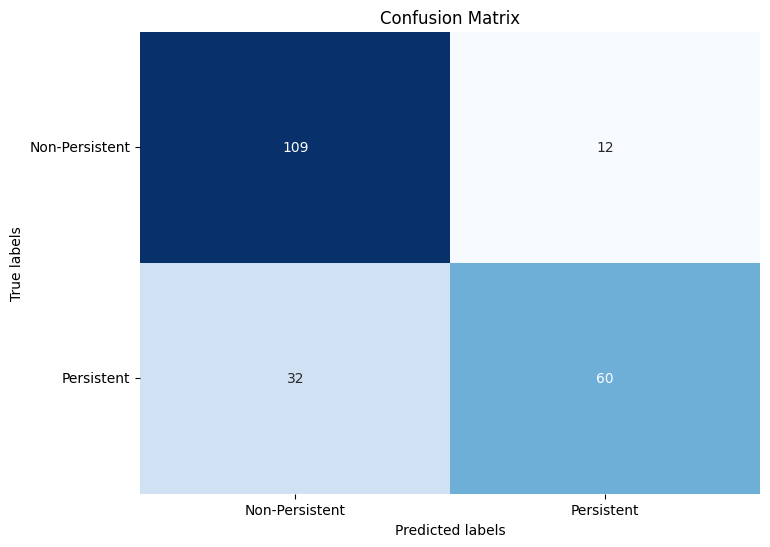

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.7730496453900709 | 0.9008264462809917 | 0.8320610687022901 |       121.0        |
|      1       | 0.8333333333333334 | 0.6521739130434783 | 0.7317073170731708 |        92.0        |
|   accuracy   | 0.7934272300469484 | 0.7934272300469484 | 0.7934272300469484 | 0.7934272300469484 |
|  macro avg   | 0.8031914893617021 | 0.7765001796622351 | 0.7818841928877305 |       213.0        |
| weighted avg | 0.7990876702294144 | 0.7934272300469484 | 0.7887157863084922 |       213.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
sgd_val_y_hat, sgd_val_acc = eval_report(best_sgd, X_val, y_val)

#### Training on Entire Test Dataset with tuned hyper-parameters

In [ ]:
# making final model using tuned hyper-parameters and X_train, y_train
sgd_final = Pipeline(steps=[
    ('preprocessor', sgd_preprocessor),
    ('classifier', SGDClassifier())
])
# setting parameters for final model
sgd_final.set_params(**best_sgd_params)
# fitting on training data
sgd_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier', SGDClassifier(alpha=0.01, max_iter=500))])

### Evaluating Optimized Model

Accuracy: 0.8010989010989011
Confusion Matrix:


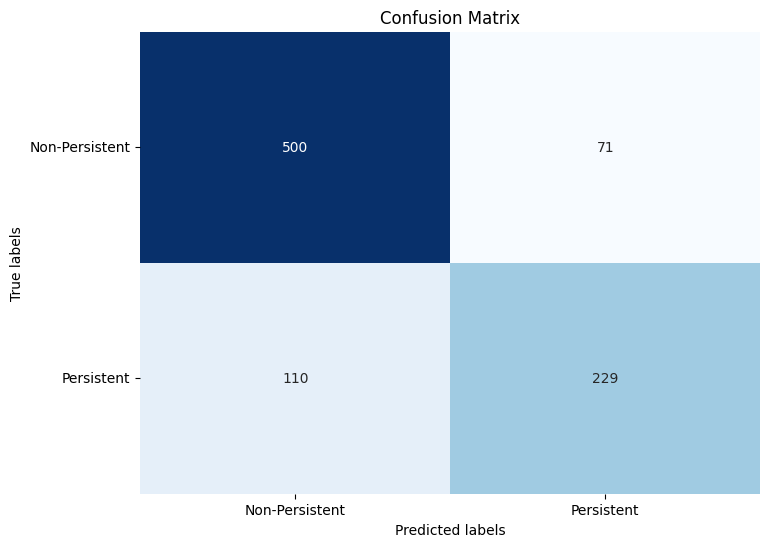

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.819672131147541  | 0.8756567425569177 | 0.8467400508044031 |       571.0        |
|      1       | 0.7633333333333333 | 0.6755162241887905 | 0.7167449139280124 |       339.0        |
|   accuracy   | 0.8010989010989011 | 0.8010989010989011 | 0.8010989010989011 | 0.8010989010989011 |
|  macro avg   | 0.7915027322404371 | 0.7755864833728541 | 0.7817424823662078 |       910.0        |
| weighted avg | 0.798684381192578  | 0.8010989010989011 | 0.7983132910229784 |       910.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on test data
y_hat_sgd, accuracy_sgd = eval_report(sgd_final, X_test, y_test)

#### Getting Feature Importance for SGD

In [ ]:
# getting labeleing model weights
sgd_l_w = get_weights(best_sgd.named_steps['classifier'], X_train.columns)
# getting model weights sorted in descending magnitutde order
sgd_l_w_sort = sort_labeled_weights(sgd_l_w)

In [ ]:
# displaying top n weights
display_top_n_weights(sgd_l_w_sort, 20)

                                                           Features   Weights
0                                                    Dexa_During_Rx  0.936394
1                             Comorb_Long_Term_Current_Drug_Therapy  0.530128
2                                               Dexa_Freq_During_Rx  0.428542
3                                             Concom_Viral_Vaccines  0.406266
4                                 Concom_Broad_Spectrum_Penicillins  0.386448
5            Comorb_Encounter_For_Screening_For_Malignant_Neoplasms  0.383971
6              Comorb_Other_Disorders_Of_Bone_Density_And_Structure  0.379017
7                                Ntm_Speciality_Bucket_Endo/Onc/Uro  0.344335
8                                 Comorb_Encounter_For_Immunization  0.314609
9                                           Ntm_Speciality_ONCOLOGY  0.265064
10                                                    Idn_Indicator  0.265064
11                                      Comorb_Vitamin_D_Deficie

#### Adding Trained Models to Log

In [ ]:
# recording results of SGD model training
sgd_result = {
    'model_name': 'sgd',
    'fitted_model': sgd_final,
    'best_params': best_sgd_params,
    'training_accuracy': sgd_training_score,
    'test_predictions': y_hat_sgd,
    'test_accuracy': accuracy_sgd,
    'labeled_final_weights': sgd_l_w,
    'sorted_labeled_weights': sgd_l_w_sort,
}
# adding SGD results
update_model_log(models_log, 'sgd', sgd_result)

New entry sgd added to models_log, number of trained models = 8


## Logistic Regression

### Loading Packages

In [ ]:
from sklearn.linear_model import LogisticRegression

### Instantiating Model Training Info

In [ ]:
# getting appropriate preprocessor for numerical data
lr_preprocessor = pre_processing_log['std']

# instantiating Logistic Regression classifier
lrc = LogisticRegression()

# instantiating pipeline for model training
lr_model = Pipeline(steps=[('preprocessor',lr_preprocessor),('classifier', lrc)])

# defining parameter grid for GridSearchCV
lr_param_grid = {
    'classifier__penalty': ['l1','l2','elasticnet'], # penalties on weights
    'classifier__random_state': ['42',None], # randomize weights
    'classifier__solver': ['lbfgs','liblinear','newton-cholesky'], # different solver types
    'classifier__max_iter': [100,200,300,400,500], # maximum number of iterations
}

# instantiating GridSearchCV
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy')

### Optimizing Model

#### Hyper-Parameter Tuning

In [ ]:
# filter warnings
suppress_warning([FitFailedWarning, UserWarning])
# running grid search to tune hyper-parameters
best_lr, best_lr_params, lr_training_score = run_grid_search('Logistic Regression', lr_grid, X_tr, y_tr) # used to be X_train, y_train

Running Grid Search for Logistic Regression
Best Accuracy: 0.8047120418848168
Best Parameters: 
{'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__random_state': None, 'classifier__solver': 'liblinear'}


Accuracy: 0.8169014084507042
Confusion Matrix:


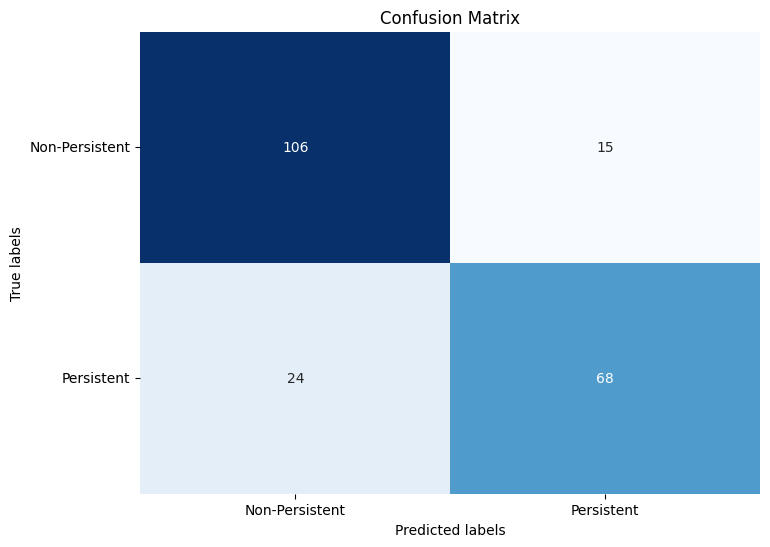

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.8153846153846154 | 0.8760330578512396 | 0.844621513944223  |       121.0        |
|      1       | 0.8192771084337349 | 0.7391304347826086 | 0.7771428571428571 |        92.0        |
|   accuracy   | 0.8169014084507042 | 0.8169014084507042 | 0.8169014084507042 | 0.8169014084507042 |
|  macro avg   | 0.8173308619091751 | 0.8075817463169241 | 0.8108821855435401 |       213.0        |
| weighted avg | 0.8170658799879909 | 0.8169014084507042 | 0.8154758030253233 |       213.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on validation data
lr_val_y_hat, lr_val_acc = eval_report(best_lr, X_val, y_val)

#### Training on Entire Test Dataset with tuned hyper-parameters

In [ ]:
# making final model using tuned hyper-parameters and X_train, y_train
lr_final = Pipeline(steps=[
    ('preprocessor', lr_preprocessor),
    ('classifier', LogisticRegression())
])
# setting parameters for final model
lr_final.set_params(**best_lr_params)
# fitting on training data
lr_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

### Evaluating Optimized Model

Accuracy: 0.8087912087912088
Confusion Matrix:


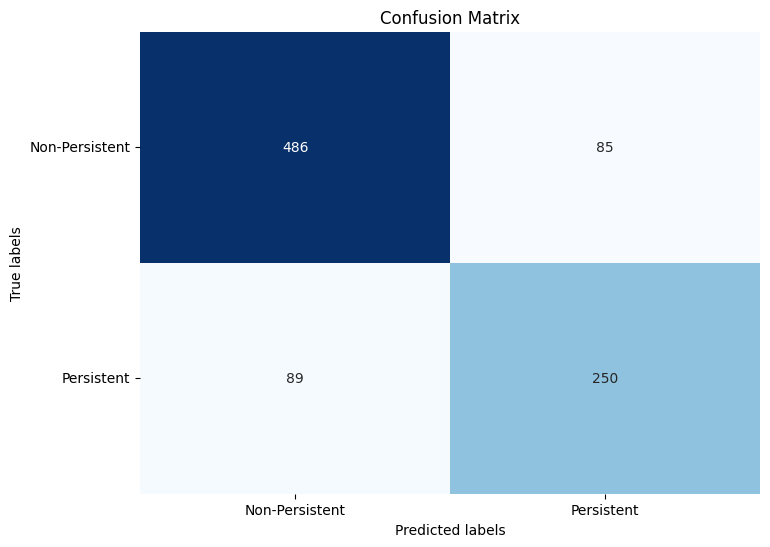

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.8452173913043478 | 0.851138353765324  | 0.8481675392670157 |       571.0        |
|      1       | 0.746268656716418  | 0.7374631268436578 | 0.741839762611276  |       339.0        |
|   accuracy   | 0.8087912087912088 | 0.8087912087912088 | 0.8087912087912088 | 0.8087912087912088 |
|  macro avg   | 0.7957430240103829 | 0.7943007403044908 | 0.7950036509391458 |       910.0        |
| weighted avg | 0.8083562692985147 | 0.8087912087912088 | 0.8085575213699874 |       910.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on test data
y_hat_lr, accuracy_lr = eval_report(lr_final, X_test, y_test) # lr_final used to best_lr

#### Getting Feature Importance for Logsitic Regression

In [ ]:
# getting labeleing model weights
lr_l_w = get_weights(best_lr.named_steps['classifier'], X_train.columns)
# getting model weights sorted in descending magnitutde order
lr_l_w_sort = sort_labeled_weights(lr_l_w)

In [ ]:
# displaying top n weights
display_top_n_weights(lr_l_w_sort, 20)

                                                           Features   Weights
0                                                    Dexa_During_Rx  1.715191
1                             Comorb_Long_Term_Current_Drug_Therapy  0.824009
2            Comorb_Encounter_For_Screening_For_Malignant_Neoplasms  0.692911
3                                             Concom_Viral_Vaccines  0.665099
4              Comorb_Other_Disorders_Of_Bone_Density_And_Structure  0.661984
5   Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx  0.604374
6                                Ntm_Speciality_Bucket_Endo/Onc/Uro  0.603372
7                                 Comorb_Encounter_For_Immunization  0.585072
8                                                  Concom_Narcotics -0.582462
9                                                     Idn_Indicator  0.563028
10                                          Ntm_Speciality_ONCOLOGY  0.521353
11                                Concom_Broad_Spectrum_Penicill

#### Adding Trained Models to Log

In [ ]:
# recording results of Logistic Regression model training
lr_result = {
    'model_name': 'logistic_regression',
    'fitted_model': lr_final, # lr_final used to be best_lr
    'best_params': best_lr_params,
    'training_accuracy': lr_val_acc,
    'test_predictions': y_hat_lr,
    'test_accuracy': accuracy_lr,
    'labeled_final_weights': lr_l_w,
    'sorted_labeled_weights': lr_l_w_sort,
}
# adding Logistic Regression results
update_model_log(models_log, 'logistic_regression', lr_result)

New entry logistic_regression added to models_log, number of trained models = 9


## Neural Network (Multi-Layer Perceptron)

### Loading Packages

In [ ]:
from sklearn.neural_network import MLPClassifier

### Instantiating Model Training Info

In [ ]:
# getting appropriate preprocessor for numerical data
mlp_preprocessor = pre_processing_log['std']
# make any additional preprocessors

# instantiating Multi-Layer Perceptron Classifier
mlpc = MLPClassifier()

# instantiating pipeline for model training
mlp_model = Pipeline(steps=[('preprocessor',mlp_preprocessor),('classifier', mlpc)])

# defining parameter grid for GridSearchCV
mlp_param_grid = {
    'classifier__activation':['logstic','tanh','relu'], # activation function
    'classifier__solver':['lbfgs','sgd','adam'], # method to optimize weights
    'classifier__max_iter':[200,300,400], # max iterations
    'classifier__random_state':[1], # random number generation for weights and biases
    'classifier__early_stopping':[True], # determines whether to stop early or not
}

# instantiating GridSearchCV
mlp_grid = GridSearchCV(mlp_model, mlp_param_grid, cv=5, scoring='accuracy')

### Optimizing Model

#### Hyper-Parameter Tuning

In [ ]:
# suppressing warnings
suppress_warning([FitFailedWarning, UserWarning, ConvergenceWarning])
# running grid search
best_mlp, best_mlp_params, mlp_training_score = run_grid_search('Multi-Layer Perceptron', mlp_grid, X_tr, y_tr)

Running Grid Search for Multi-Layer Perceptron
Best Accuracy: 0.8015706806282722
Best Parameters: 
{'classifier__activation': 'tanh', 'classifier__early_stopping': True, 'classifier__max_iter': 200, 'classifier__random_state': 1, 'classifier__solver': 'adam'}


Accuracy: 0.8215962441314554
Confusion Matrix:


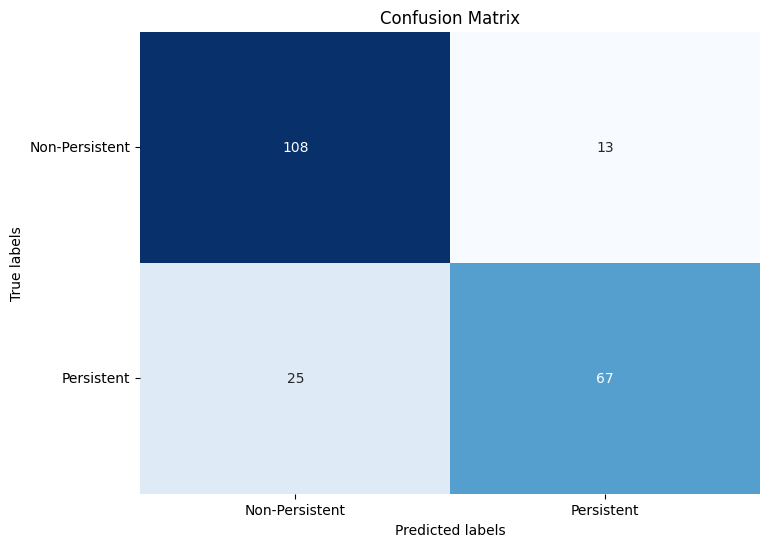

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.8120300751879699 | 0.8925619834710744 | 0.8503937007874016 |       121.0        |
|      1       |       0.8375       | 0.7282608695652174 | 0.7790697674418605 |        92.0        |
|   accuracy   | 0.8215962441314554 | 0.8215962441314554 | 0.8215962441314554 | 0.8215962441314554 |
|  macro avg   | 0.824765037593985  | 0.8104114265181459 | 0.8147317341146311 |       213.0        |
| weighted avg | 0.8230311694729782 | 0.8215962441314554 | 0.8195871192484825 |       213.0        |
+--------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
# predicting on validation data
mlp_val_y_hat, mlp_val_acc = eval_report(best_mlp, X_val, y_val)

#### Training on Entire Test Dataset with Tuned Hyper-Parameters

In [ ]:
# making final model using tuned hyper-parameters and X_train, y_train
mlp_final = Pipeline(steps=[
    ('preprocessor', mlp_preprocessor),
    ('classifier', MLPClassifier())
])
# setting parameters for final model
mlp_final.set_params(**best_mlp_params)
# fitting on training data
mlp_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['Dexa_Freq_During_Rx'])])),
                ('classifier',
                 MLPClassifier(activation='tanh', early_stopping=True,
                               random_state=1))])

### Evaluating Optimized Model

Accuracy: 0.8
Confusion Matrix:


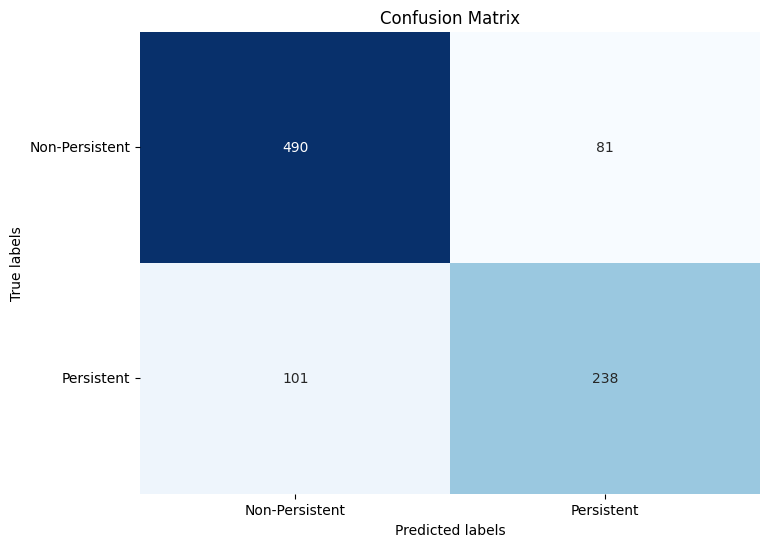

Classification Report:
+--------------+--------------------+--------------------+--------------------+---------+
|              |     precision      |       recall       |      f1-score      | support |
+--------------+--------------------+--------------------+--------------------+---------+
|      0       | 0.8291032148900169 | 0.8581436077057794 | 0.8433734939759037 |  571.0  |
|      1       | 0.7460815047021944 | 0.7020648967551623 | 0.723404255319149  |  339.0  |
|   accuracy   |        0.8         |        0.8         |        0.8         |   0.8   |
|  macro avg   | 0.7875923597961056 | 0.7801042522304709 | 0.7833888746475264 |  910.0  |
| weighted avg | 0.798175347028839  |        0.8         | 0.7986816567180578 |  910.0  |
+--------------+--------------------+--------------------+--------------------+---------+


In [ ]:
# predicting on test data
y_hat_mlp, accuracy_mlp = eval_report(mlp_final, X_test, y_test)

#### Getting feature importance

Since we are training a Neural Network, the weights will be for each layer to it's subsequent nodes, making tracking of this not realistic to do.

#### Adding Trained Models to Log

In [ ]:
# recording results of multi-layer perceptron model training
mlp_result = {
    'model_name': 'perceptron',
    'fitted_model': mlp_final,
    'best_params': best_mlp_params,
    'training_accuracy': mlp_val_acc,
    'test_predictions': y_hat_mlp,
    'test_accuracy': accuracy_mlp,
    'labeled_final_weights': None,
    'sorted_labeled_weights': None,
}
# adding multi-layer perceptron results
update_model_log(models_log, 'perceptron', mlp_result)

New entry perceptron added to models_log, number of trained models = 10


# Comparing Models

## Compare Testing and Training Accuracies Across All Models

In [ ]:
# plots the test_accuracy compared to the training accuracy across all models in a bar chart
# model_names: array of model names, should be the keys for the models_log dictionary
# model_dict: the contents of the models_log dictionary
def plot_models_performance(model_names, model_dict):
    # Extract training and testing accuracies from the dictionary for each model
    acc_train = [model_dict[name]['training_accuracy'] for name in model_names]
    acc_test = [model_dict[name]['test_accuracy'] for name in model_names]

    fig, ax = plt.subplots(figsize=(20, 8))

    # Set the indices for the models
    index = np.arange(len(model_names))
    bar_width = 0.35

    # Create bars for training and testing accuracies
    train_bar = ax.bar(index, acc_train, bar_width, label='Train Accuracy')
    test_bar = ax.bar(index + bar_width, acc_test, bar_width, label='Test Accuracy')

    # Adding Percentage to each bar
    ax.bar_label(train_bar, fmt='%.4f', padding=3) # training accuracy
    ax.bar_label(test_bar, fmt='%.4f', padding=3) # training accuracy

    # adjusting size of plot
    ax.set_ylim(0.5,1.0)

    # labeling plot
    ax.set_xlabel('Model Names')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training vs Testing Accuracy per Model')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(model_names)
    ax.legend()
    plt.show()

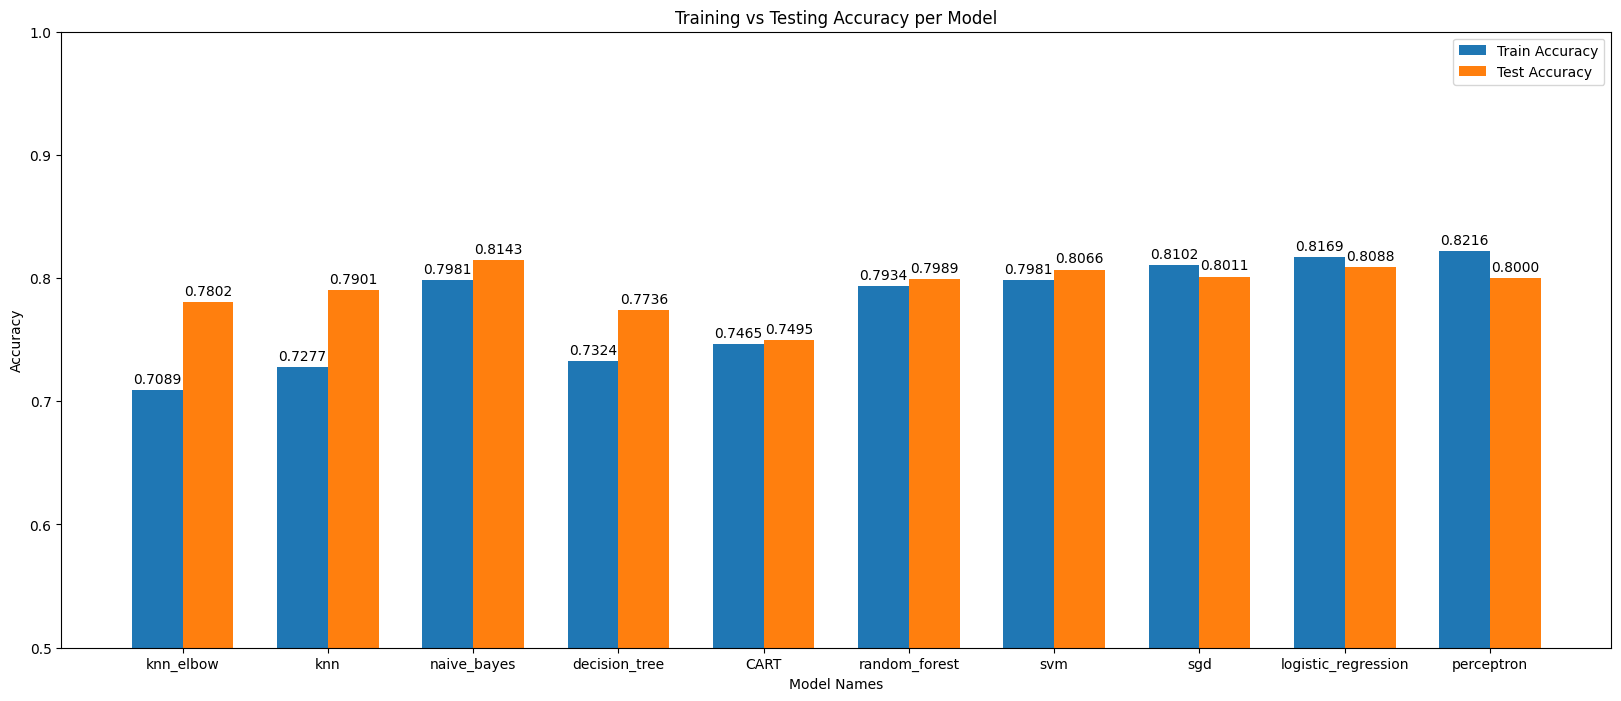

In [ ]:
plot_models_performance(list(models_log.keys()), models_log)

Compare models performance in relationship to the data distribution of the target

In [ ]:
# getting counts of each value in target column
target_val_counts = df_clean['Persistency_Flag'].value_counts()
print(f'Breakdown of Target (0 = Not_persistent, 1 = Persistent):\n{target_val_counts}')
print(f'Percent Persistent {target_val_counts[1]/len(df_clean["Persistency_Flag"])}')
print(f'Percent Non-Persistent: {target_val_counts[0]/len(df_clean["Persistency_Flag"])}')

Breakdown of Target (0 = Not_persistent, 1 = Persistent):
Persistency_Flag
0    1867
1    1166
Name: count, dtype: int64
Percent Persistent 0.38443785031322125
Percent Non-Persistent: 0.6155621496867788


All of the models perform with an accuracy greater than 0.6156.  
This means, that they perform better than the baseline of always predicting Non-Persistent (0).  
This means that our models have good performance on this dataset.

### Examining Feature Weights Across Models

In [ ]:
# returns dictionary of all sorted model weights, each entry is the list of model weights for a model
# model_names: array of model names, should be the keys for the models_log dictionary
# model_dict: the contents of the models_log dictionary
def get_all_weights(model_names, model_dict):
  all_weights = {} # stores results

  # going through all models
  for model in model_names:
    curr_model_info = model_dict[model] # current model info
    curr_sorted_weights = curr_model_info['sorted_labeled_weights']
    if curr_sorted_weights is not None: # model has weights
      all_weights[model] = curr_sorted_weights

  return all_weights

In [ ]:
# returns list of the mean model weights, sorted in descending order by magnitude
# model_names: array of model names, should be the keys for the dictionary returned by get_all_weights()
# model_dict: the dictionary returned by get_all_weights()
# n: first n number of weights to consider, default is n=10
def mean_weights_n(model_names, model_weights_dict, n=10):
  # dictionary to hold list of weights for each feature
  feat_weights = {}
  mean_weights = []

  # go through all models
  for model in model_names:
    curr_weights = model_weights_dict[model]
    # go through n weights
    for i in range(min(n, len(curr_weights))):
      feat, weight = curr_weights[i] # unpacking
      # updating feat_weights with current weight
      if feat in feat_weights: # add to list
        feat_weights[feat].append(weight)
      else: # make list
        feat_weights[feat] = [weight]

  # calcualting mean weight
  for feat, weights in feat_weights.items():
    curr_mean_weight = np.mean(weights) # calculating mean weight
    mean_weights.append((feat, curr_mean_weight))

  # sorting mean_weights by magnitude
  mean_weights_sorted = sorted(mean_weights, key=lambda x: abs(x[1]), reverse=True)

  return mean_weights_sorted

In [ ]:
# returns list of the mean model weights, sorted in descending order by frequency appearing in top n position in sorted_labeled_weights
# model_names: array of model names, should be the keys for the dictionary returned by get_all_weights()
# model_dict: the dictionary returned by get_all_weights()
# n: first n number of weights to consider, default is n=10
def weights_top_n_freq(model_names, model_weights_dict, n=10):
  # dictionary to hold list of weights for each feature
  feat_freq = {}
  top_feats = []

  # go through all models
  for model in model_names:
    curr_weights = model_weights_dict[model]
    # go through n features
    for i in range(min(n, len(curr_weights))):
      feat, _ = curr_weights[i] # unpacking
      # updating feat_freq
      if feat in feat_freq: # increase frequency
        feat_freq[feat] += 1
      else: # add to frequency
        feat_freq[feat] = 1

  # turning dictionary into list of tuples
  for feat, freq in feat_freq.items():
    top_feats.append((feat, freq))

  # sorting top_feats in descending order
  top_feats_sorted = sorted(top_feats, key=lambda x: x[1], reverse=True)

  return top_feats_sorted

In [ ]:
# takes in info from mean_weights_sorted or weights_top_n_freq and displays them
# organized_feat_weight: list of (feat, weight) tuples, result of mean_weights_sorted or weights_top_n_freq
# count: if False, Second column will be labeled as weight, else Frequency
def display_feature_info(organized_feat_weight, count=False):
      features, info = zip(*organized_feat_weight)
      column_name = 'Frequency' if count else 'Weights'
      organized = {'Features': features, column_name: info}
      top_n = pd.DataFrame(organized)
      print(top_n.to_string())

In [ ]:
all_model_weights = get_all_weights(list(models_log.keys()), models_log)
print(all_model_weights)

{'decision_tree': [('Dexa_Freq_During_Rx', 0.3724563967763676), ('Comorb_Encounter_For_Immunization', 0.0788167701268597), ('Comorb_Long_Term_Current_Drug_Therapy', 0.05860060877988495), ('Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 0.035540582812423956), ('Comorb_Vitamin_D_Deficiency', 0.028533235242789133), ('Concom_Fluoroquinolones', 0.02295374100901129), ('Concom_Cholesterol_And_Triglyceride_Regulating_Preparations', 0.022677638839531812), ('Concom_Macrolides_And_Similar_Types', 0.02265116608238936), ('Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 0.022163803215794413), ('Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 0.021609634123740465), ('Ntm_Speciality_Bucket_Endo/Onc/Uro', 0.021480001426494016), ('Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias', 0.021427114353108196), ('Ntm_Specialist_Flag_Specialist', 0.01909853604832568), ('Ntm_Speciality_GENERAL PRACTITIONER', 0.018784705615539868), ('Gluco_Record_During_Rx', 0.

In [ ]:
mean_weights_sorted = mean_weights_n(list(all_model_weights.keys()), all_model_weights)
display_feature_info(mean_weights_sorted)

                                                           Features   Weights
0                                                    Dexa_During_Rx  0.913004
1                                                  Concom_Narcotics -0.582462
2                                             Concom_Viral_Vaccines  0.535683
3                                Ntm_Speciality_Bucket_Endo/Onc/Uro  0.473854
4                                 Concom_Broad_Spectrum_Penicillins  0.386448
5              Comorb_Other_Disorders_Of_Bone_Density_And_Structure  0.355627
6                                               Dexa_Freq_During_Rx  0.349635
7                             Comorb_Long_Term_Current_Drug_Therapy  0.303110
8                                                     Idn_Indicator  0.292475
9                                           Ntm_Speciality_ONCOLOGY  0.265064
10           Comorb_Encounter_For_Screening_For_Malignant_Neoplasms  0.234119
11                                Comorb_Encounter_For_Immunizat

In [ ]:
top_feats_sorted = weights_top_n_freq(list(all_model_weights.keys()), all_model_weights)
display_feature_info(top_feats_sorted, count=True)

                                                           Features  Frequency
0                                 Comorb_Encounter_For_Immunization          5
1                             Comorb_Long_Term_Current_Drug_Therapy          5
2            Comorb_Encounter_For_Screening_For_Malignant_Neoplasms          5
3                                               Dexa_Freq_During_Rx          4
4   Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx          4
5                                                    Dexa_During_Rx          3
6              Comorb_Other_Disorders_Of_Bone_Density_And_Structure          3
7                                       Comorb_Vitamin_D_Deficiency          2
8                                           Concom_Fluoroquinolones          2
9                               Concom_Macrolides_And_Similar_Types          2
10         Comorb_Personal_History_Of_Other_Diseases_And_Conditions          2
11                                                  

# Conclusion

Overall Performance:
* All models perform well above the base threshold of 61.56% accuracy
  * most perform at around 80% accuracy

Notes on Models Specifically:
* Best Peforming Model: Naive Bayes, Accuracy: 81.43%
  * This could be because a majority of the data is categorical data that was One-Hot Encoded
* Decision Tree models performed the worst on average
* Modles that utilized linear decision boundaries performed better on average

Notes on Data itself:
* A significant amount of features do not have much of a correlation to the target variable
  * Exact number is 79

Features to Note:  
* Dexa_During_Rx
  * Most common factor to affect Persistency
  * DEXA is a specialized x-ray scan to measure bone density
  * A patient is more likely to be persistent with their medication if they have frequent DEXA scans because they are in frequent contact with their doctor and medical testing.
* Comorb_\<One-Hot Encoded Feature\>
  * Multiple One-Hot Encoded features included Comorb → Comorbidity is a commonality
 * Comorb_<> have positive mean weights → Persistent prediction
* Concom_Narcotics
  * Presence of narcotics within patient medical records leads to non-persistence when starting a new therapy regimen
